# Preparation

In [ ]:
!pip install geopandas
!pip install lightfm
!pip install python-louvain
!pip install matplotlib
!pip install seaborn

In [2]:
import re, itertools, random, collections, time, requests

import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from scipy import sparse
from scipy.sparse import csr_matrix, hstack

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

import networkx as nx
from networkx.algorithms import bipartite
from community import community_louvain

import matplotlib.pyplot as plt
import seaborn as sns

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

from operator import *

try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

%matplotlib inline

# Functions

In [3]:
def show_hist1(col,df,hor):  
  if hor:    
    plt.figure(figsize=(8,4))
    ax = sns.countplot(x=col, data=df, order = col.value_counts().index)
  else:    
    plt.figure(figsize=(6,15))
    ax = sns.countplot(y=col, data=df, order = col.value_counts().index)
  
  ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha="right", fontsize=7)
  ax.set_yticklabels(ax.get_yticklabels(), ha="right", fontsize=7)
  plt.tight_layout()
  plt.show()

def show_hist2(col,df):
  plt.figure(figsize=(8,6))
  ax=sns.barplot(x=col[0], y=col[1], data=df)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha="right", fontsize=8)
  plt.tight_layout()
  plt.show()

def get_boundingbox_spot(spot, conORcit, output_as='boundingbox'):
    # create url
    output = [0,0]
    try:
      if conORcit == "country":
        url = '{0}{1}{2}'.format('http://nominatim.openstreetmap.org/search?country=',
                                spot, '&format=json&polygon=0')
      else:
        url = '{0}{1}{2}'.format('http://nominatim.openstreetmap.org/search?city=',
                                spot, '&country=uk&format=json&polygon=0')
      response = requests.get(url).json()[0]

      # parse response to list
      if output_as == 'boundingbox':
          lst = response[output_as]
          output = [float(i) for i in lst]
      if output_as == 'center':
          lst = [response.get(key) for key in ['lat','lon']]
          output = [float(i) for i in lst]
    except:
      pass
    return output

def get_df_con(list_spot, conORcit):
  k = 0
  simple =[]
  for i in list_spot:
    #if k<20:
      LatLong = get_boundingbox_spot(spot=i, conORcit=conORcit, output_as="center")
      simple.append([i, LatLong[0], LatLong[1]]) 
      #print(i, LatLong)
      k+=1

  df_c=pd.DataFrame(simple,columns=['spot','lat','lon'])

  df_c.drop_duplicates()
  df_c = df_c.dropna()
  df_c = df_c[df_c['lat'] != 0]
  df_c = df_c[df_c['lon'] != 0]
  return df_c

In [4]:
def create_cat(fileCat, dfClean, COI):
  with open(fileCat) as f: cat_product_type = f.readlines()
  # remove whitespace characters like `\n` at the end of each line
  # cat_product_type = [x.strip() for x in content] 
  k=1
  dictProdCat = {}
  for i in cat_product_type:
    i = i.replace("\'","")
    tmpTy = re.findall(r'\((.*?)\)', i)
    #print(k, tmpTy)
    dictProdCat.update({"cat"+str(k):tmpTy})
    #print("-"*50)
    k+=1

  k=0
  for key, val in dictProdCat.items():
    #if k < 2:
      #print(key,val)
      tmpIdxProdTy = []
      for i in val:
        tmpIdxProdTy.append(dfClean.index[dfClean[COI].str.replace("\'","") == i].tolist())
      IdxProdTy = list(itertools.chain(*tmpIdxProdTy))
      #print(IdxProdTy)
      dfClean.loc[IdxProdTy,'product_cat'] = key
      k+=1

  return dfClean, dictProdCat

In [5]:
def mat_nxn(n, df_bin):
  prod_int = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      if i != j:
        df_ij = df_bin.iloc[:,[i,j]] 
        sum_ij = df_ij.sum(axis=1)
        pairings_ij = len(sum_ij[sum_ij == 2]) 
        prod_int[i,j] = pairings_ij
        prod_int[j,i] = pairings_ij

  #Count how many customers have purchased each item
  print('Counting how many times each individual product has been purchased...')
  prod_timeBuy = prod_int.sum(axis = 1)
  return prod_timeBuy, prod_int


def mat_weight(n, prod_timeBuy, prod_int):
  #Construct final weighted matrix of item interactions
  print('Building weighted product matrix...')
  prod_weiBuy = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      #make sure you do not divide with zero
      if (prod_timeBuy[i]+prod_timeBuy[j]) !=0: 
        prod_weiBuy[i,j] = (prod_int[i,j])/(prod_timeBuy[i]+prod_timeBuy[j])
  return prod_weiBuy


def mtx_prob(df_weiBuy, labs):
  df_prod_weiBuy = pd.DataFrame(df_weiBuy, columns = list(labs.values()))
  df_prod_weiBuy.set_index(df_prod_weiBuy.columns, 'product', inplace=True)
  prod_prob = df_prod_weiBuy.divide(df_prod_weiBuy.max(axis = 1), axis = 0)
  return prod_prob

In [6]:
def distNode(G_Ref_nx):
  gRef_degree = dict(nx.degree(G_Ref_nx))
  gRef_degree = dict(sorted(gRef_degree.items(), key=lambda item: item[1]))
  print(gRef_degree)

  maxD=0; maxN=""
  for key,val in gRef_degree.items():
    if val > maxD: maxD=val; maxN=key
  print("Node with the highest degree:",maxN,maxD) 

  plt.figure(figsize=(5,15))
  #plt.ylim(min(gRef_degree.values()),max(gRef_degree.values()))
  plt.barh(list(range(0, G_Ref_nx.number_of_nodes())), 
          gRef_degree.values(), color='g')
  plt.show()

def distComp(g_nx):
  UG2 = list(nx.connected_components(g_nx))
  print("Number of components/islands:", len(UG2))

  nInCom0=[]
  for i in range(len(UG2)):
    if len(UG2[i]) not in nInCom0:
      nInCom0.append(len(UG2[i]))
  print("#Nodes in a component:", nInCom0)

  nInCom1=[0]*len(nInCom0)
  for i in range(len(UG2)):
    nInCom1[nInCom0.index(len(UG2[i]))] = nInCom1[nInCom0.index(len(UG2[i]))]+1
  print("#Componets:", nInCom1)

  nInCom2 = [len(UG2[x]) for x in range(len(UG2))]

  plt.figure(figsize=(5,5))
  plt.bar([str(nInCom0[i]) for i in range(len(nInCom0))], nInCom1, color='g')
  plt.ylabel('#Component')
  plt.xlabel('#Nodes')

  xlocs, xlabs = plt.xticks()
  for i, v in enumerate(nInCom1):
      plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
  plt.show()

In [7]:
def save_graph(g_nx, nFile, pos, labs):
  nx.draw_networkx_nodes(g_nx, pos, node_color="skyblue", node_size=30)
  nx.draw_networkx_edges(g_nx, pos, edge_color='k', width= 0.3, alpha= 0.5)
  nx.draw_networkx_labels(g_nx, pos, labs, font_size=4)
  plt.axis('off')
  plt.show() # display

  #Export graph to Gephi
  #create a new graph with Description labels and save to Gephi for visualizations
  g_gf=nx.relabel_nodes(g_nx,labs)
  nx.write_gexf(g_gf, nFile+".gexf")
  nx.write_gml(g_nx, nFile+".gml")

In [8]:
def rec_prod(prod, prod_prob, numSug):
  basket = prod
  no_of_suggestions = numSug

  all_of_basket = prod_prob[basket]
  all_of_basket = all_of_basket.sort_values(by = basket, ascending=False)
  
  suggestions_to_customer = list(all_of_basket.index[:no_of_suggestions])

  return suggestions_to_customer

In [9]:
def mod_Louv(g_nx, labs):
  #Find communities of nodes (products)
  partition = community_louvain.best_partition(g_nx, resolution = 1.0)
  print(len(partition))
  values = list(partition.values())
  print(len(values))
  print('Number of communities:', len(np.unique(values)))

  #Create dataframe with product description and community id
  prod_comm = pd.DataFrame(list(labs.values()), columns = ['product_description'])
  prod_comm['community_id'] = values

  return prod_comm

In [10]:
def get_prodMore2Cust(df):
  dfx = df[['customer_id','product_id']]
  dfx

  dfx_gr = dfx.groupby('product_id').agg('count')
  dfx_gr

  dfx.loc[dfx['product_id'] == 6455427716]

  dfx_more2 = dfx_gr.loc[dfx_gr['customer_id'] > 1]
  dfx_more2

  listProdId_more2 = dfx_more2.index.to_list()

  return listProdId_more2
  

def create_map(theDF, theID):
  np_theID = np.sort(theDF[theID].unique())
  print("Total", theID, ":",len(np_theID))

  map_Xxx2Idx = {} ; map_Idx2Xxx = {}
  for idx, xxx in enumerate(np_theID):
    map_Xxx2Idx[xxx] = idx
    map_Idx2Xxx[idx] = xxx

  return map_Xxx2Idx, map_Idx2Xxx

In [11]:
def build_cooMat(theDL, mapR, mapC, titR, titC, theWay):
  k=0; coo_r = []; coo_c = []; coo_v = []

  for idx,row in theDL.iterrows():  
    #if k<2:
      if theWay == "way1":
        #print(idx, row[titR], row[titC])
        tmpR = mapR[row[titR]]
        tmpC = mapC[row[titC]]
        tmpV = 1
        #print(">", tmpR, tmpC)
        coo_r.append(tmpR); coo_c.append(tmpC); coo_v.append(tmpV)
        #for key,val in row.to_dict().items():  print("  ",key,":", val)

      if theWay == "way2":
        #print(idx)
        for key,val in row.to_dict().items():
          if val != 0: 
            coo_r.append(mapR[idx]); coo_c.append(mapC[key]); coo_v.append(val)
            #print("  ",key, val, "->", map_Usr2Idx[idx], map_Pro2Idx[key])
      #print("-"*25)

      if theWay == "way3":
        i=0
        for key,val in row.to_dict().items():
          if key != titR:
            coo_r.append(mapR[row[titR]])
            coo_c.append(i)
            coo_v.append(val)
            #print(mapR[row[titR]],i, key,val)
            i+=1

      if theWay == "way4":
        #print(idx,row[titR],row[titR])
        tmpR = mapR[row[titR]]
        tmpC = mapC[0]
        tmpV = row[titC]
        coo_r.append(tmpR); coo_c.append(tmpC); coo_v.append(tmpV)

      k+=1

  matCoo = sparse.coo_matrix((
    np.array(coo_v),
    (np.array(coo_r), np.array(coo_c))),
    shape = (len(mapR), len(mapC))
  )

  return matCoo

In [12]:
def build_rmfv(df):
  
  # ===========================================================================
  print("Total unique customers:", df['customer_id'].nunique())
  #now = dt.date(2021, 4, 1) # just take the max date from the index + 1
  now = dt.date.today()
  print("Date today:",now)

  # ===========================================================================
  # RECENCY
  df_recency = df.groupby('customer_id').day.max().reset_index()
  df_recency.columns = ['customer_id','last_purchase']
  df_recency
  df_recency['last_date'] =  pd.DatetimeIndex(df_recency['last_purchase'], dayfirst=True).date
  df_recency
  df_recency['recency'] = df_recency['last_date'].apply(lambda x: (now - x).days)
  df_recency = df_recency[['customer_id', 'recency']]
  df_recency

  # ===========================================================================
  # FREQUENCY
  df_frequency = df.groupby('customer_id')['order_id'].count().reset_index()
  #df_frequency = df_sales_clean.groupby('customer_id')['day'].count().reset_index()
  df_frequency.columns = ['customer_id','frequency']
  df_frequency

  # ===========================================================================
  # MONETARY
  df_monetary = df.groupby('customer_id')['net_sales'].sum().reset_index()
  df_monetary.columns = ['customer_id','monetary']
  df_monetary

  # ===========================================================================
  # VARIETY
  df_variety = df.groupby('customer_id')['product_id'].nunique().reset_index()
  df_variety.columns = ['customer_id','variety']
  df_variety

  # ===========================================================================
  # DF user features
  df_rfmv = df_recency.copy()
  df_rfmv = df_rfmv.merge(df_frequency, on='customer_id')
  df_rfmv = df_rfmv.merge(df_monetary, on='customer_id')
  df_rfmv = df_rfmv.merge(df_variety, on='customer_id')
  
  return df_rfmv

In [13]:
## create a function that returns a score--0 to 4 based on the quartile ranking
## these score can be easily interpreted by the K-Mean algorithm instead of the 
## actual value of RFMB

### recency score: the lower the recency, the higher the score 
def RecencyScore(i, col, df):
    if i <= df[col][0.25]:
        return 4
    elif i <= df[col][0.50]:
        return 3
    elif i <= df[col][0.75]: 
        return 2
    else:
        return 1
    
# F, M, V: In contrast to Recency, the higher the quantile value, the higher the score    
def FMVScore(i, col, df):
    if i <= df[col][0.25]:
        return 1
    elif i <= df[col][0.50]:
        return 2
    elif i <= df[col][0.75]: 
        return 3    
    else:
        return 4

In [14]:
def create_Usr_cluster(df_rfmv):

  ### we take the 25%, 50%, and 75% quantile for each of R, F, M, and V and store them into dictionary data type
  rfmv_quantiles = df_rfmv.iloc[:, 1:].quantile(q = [0.25, 0.5, 0.75]).to_dict()
  rfmv_quantiles

  # ===========================================================================
  tmp_rfmv = df_rfmv.copy()

  tmp_rfmv['R_q'] = tmp_rfmv['recency'].apply(RecencyScore, args=('recency', rfmv_quantiles ))
  tmp_rfmv['F_q'] = tmp_rfmv['frequency'].apply(FMVScore, args=('frequency', rfmv_quantiles ))
  tmp_rfmv['M_q'] = tmp_rfmv['monetary'].apply(FMVScore, args=('monetary', rfmv_quantiles ))
  tmp_rfmv['V_q'] = tmp_rfmv['variety'].apply(FMVScore, args=('variety', rfmv_quantiles ))

  tmp_rfmv = tmp_rfmv[['customer_id', 'R_q', 'F_q', 'M_q', 'V_q',]]

  # # Sum total scores of each component
  tmp_rfmv['Total_Score'] = tmp_rfmv['R_q'] + tmp_rfmv['F_q'] + tmp_rfmv['M_q'] + tmp_rfmv['V_q']
  tmp_rfmv = tmp_rfmv[['customer_id', 'Total_Score']]

  # IMPORTANT: set index to customer number
  tmp_rfmv.index = tmp_rfmv['customer_id']
  tmp_rfmv = tmp_rfmv.drop('customer_id', 1)

  # ===========================================================================
  # We use elbow method to find the optimal number of clusters 

  wcss = []
  for i in range(2,10):
      kmeans = KMeans(n_clusters=i, 
                      init='k-means++')
      kmeans.fit(tmp_rfmv)
      wcss.append(kmeans.inertia_)      
  # Plot the graph for Elbow Method
  plt.plot(range(2,10), wcss)
  plt.title('Elbow graph')
  plt.xlabel('Cluster number')
  plt.ylabel('WCSS')
  plt.show()

  return tmp_rfmv

In [15]:
def plot_cluster(df_rfmv):
  fig, ax = plt.subplots(figsize=(12,8))

  var1 = 'frequency'
  var2 = 'monetary'
  temp = df_rfmv.copy()

  c1 = temp[temp.clusters == 0]
  c2 = temp[temp.clusters == 1]
  c3 = temp[temp.clusters == 2]
  c4 = temp[temp.clusters == 3]
  #c5 = temp[temp.clusters == 4]
  #c6 = temp[temp.clusters == 5]

  # Visualization of the clusters
  plt.scatter(c1[var1], c1[var2], c = 'b', label = 'Cluster 1', s=8)
  plt.scatter(c2[var1], c2[var2], c = 'r', label = 'Cluster 2', s=8)
  plt.scatter(c3[var1], c3[var2], c = 'g', label = 'Cluster 3', s=8)
  plt.scatter(c4[var1], c4[var2], c = 'k', label = 'Cluster 4', s=8)
  #plt.scatter(c5[var1], c5[var2], c = 'c', label = 'Cluster 5', s=8)
  #plt.scatter(c6[var1], c6[var2], c = 'y', label = 'Cluster 6', s=8)

  plt.title('Clusters of customers', size=20)
  plt.xlabel(var1, size=20)
  plt.ylabel(var2, size=20)
  plt.legend(fontsize=20)

In [16]:
def create_cleanTrTe(np_Usr, np_Pro, df_sales_clean):
  df_sales_clean = df_sales_clean[df_sales_clean['customer_id'].isin(np_Usr.tolist())]
  df_sales_clean = df_sales_clean[df_sales_clean['product_id'].isin(np_Pro.tolist())]

  # Check interaction matrix row (user) and col (prod)
  print("Total row/users:",df_sales_clean['customer_id'].nunique())
  print("Total col/products:",df_sales_clean['product_id'].nunique())

  return df_sales_clean

In [17]:
def combined_train_test(train, test):
  
    # initialising train dict
    train_dict = {}
    for train_row, train_col, train_data in zip(train.row, train.col, train.data):
        train_dict[(train_row, train_col)] = train_data
        
    # replacing with the test set
    
    for test_row, test_col, test_data in zip(test.row, test.col, test.data):
        train_dict[(test_row, test_col)] = max(test_data, train_dict.get((test_row, test_col), 0))
        
    
    # converting to the row
    row_element = []
    col_element = []
    data_element = []
    for row, col in train_dict:
        row_element.append(row)
        col_element.append(col)
        data_element.append(train_dict[(row, col)])
        
    # converting to np array
    
    row_element = np.array(row_element)
    col_element = np.array(col_element)
    data_element = np.array(data_element)
    
    return sparse.coo_matrix((data_element, (row_element, col_element)), shape = (train.shape[0], train.shape[1]))

In [18]:
def recommendation_for_user(model, user, items, dictItems, dictUsers,
                            user_to_index_mapping,
                            user_to_product_interaction,
                            nRec):
    user2index_map = user_to_index_mapping
    user_to_product_interaction_matrix = user_to_product_interaction
    items = items

    # getting the userindex        
    userindex = user2index_map.get(user, None)
    #print("userindex:",userindex)
    
    if userindex == None: return None
    users = userindex
    #print("user:",users)

    # products already bought        
    known_positives = items[user_to_product_interaction_matrix.tocsr()[userindex].indices]
    
    # scores from model prediction
    scores = model.predict(user_ids = users, 
                           item_ids = np.arange(user_to_product_interaction_matrix.shape[1]))
    #print("scores:",scores)
    
    # top items        
    top_items = items[np.argsort(-scores)]
    
    # printing out the result
    print("User:", user, "with features:", dictUsers[user])
    print("     Known positives:")
    
    for x in known_positives[:nRec]:
        print("       ",x, dictProd[x])
        
    print("     Recommended product:")
    for x in top_items[:nRec]:
      if x not in known_positives:
        print("       ",x, dictProd[x])

In [19]:
def build_model(matCoo_tr, matCoo_te, 
               matCoo_Usrfeat, matCoo_Profeat,
               nEpoch, nThread):

  # initialising model with warp loss function
  theModel = LightFM(loss = "warp")

  # fitting the model
  start = time.time()
  #===================
  theModel.fit(matCoo_tr,
            user_features=matCoo_Usrfeat, item_features=matCoo_Profeat, 
            sample_weight=None, 
            epochs=nEpoch, num_threads=nThread,
            verbose=False)
  #===================
  end = time.time()
  #print("time taken = {0:.{1}f} seconds".format(end - start, 2))

  start = time.time()
  #===================
  # auc metric score (ranging from 0 to 1)
  theAUC = auc_score(model = theModel, 
                     test_interactions = matCoo_te,
                     train_interactions = matCoo_tr, 
                     item_features = matCoo_Profeat,
                     user_features = matCoo_Usrfeat,                     
                     num_threads = nThread, check_intersections=False)
  #===================
  end = time.time()
  #print("time taken = {0:.{1}f} seconds".format(end - start, 2))
  print("avg AUC = {0:.{1}f}".format(theAUC.mean(), 2))

  trPrec = precision_at_k(theModel, 
                          test_interactions = matCoo_tr,
                          train_interactions = None, 
                          user_features=matCoo_Usrfeat, 
                          item_features=matCoo_Profeat,
                          k=10).mean()
  print("train precision:",trPrec)
  tePrec = precision_at_k(theModel, 
                          test_interactions = matCoo_te,
                          train_interactions = None, 
                          user_features=matCoo_Usrfeat, 
                          item_features=matCoo_Profeat,
                          k=10).mean()
  print("test precision:",tePrec)

  trReca = recall_at_k(theModel, 
                          test_interactions = matCoo_tr,
                          train_interactions = None, 
                          user_features=matCoo_Usrfeat, 
                          item_features=matCoo_Profeat,
                          k=10).mean()
  print("train recall:",trReca)
  teReca = recall_at_k(theModel, 
                          test_interactions = matCoo_te,
                          train_interactions = None, 
                          user_features=matCoo_Usrfeat, 
                          item_features=matCoo_Profeat,
                          k=10).mean()
  print("test recall:",teReca)
  
  return theAUC.mean(), trPrec, tePrec, trReca, teReca

# EDA

In [23]:
df_sales = pd.read_csv('sales_2018-01-01_2021-02-16.csv')
df_sales['day'] = pd.to_datetime(df_sales['day'])
df_sales

,day,order_id,sale_kind,billing_city,billing_country,customer_id,customer_type,product_id,product_price,product_title,product_type,product_vendor,variant_id,variant_sku,variant_title,api_client_title,shipping_city,shipping_country,orders,gross_sales,discounts,returns,net_sales,shipping,taxes,total_sales,total_cost,net_quantity,ordered_item_quantity,returned_item_quantity
0,2018-01-01,275211943963,order,Exeter,United Kingdom,337253793819,First-time,0,0.00,NaN,NaN,NaN,0,NaN,NaN,Online Store,Exeter,United Kingdom,0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0,0,0
1,2018-01-01,275211943963,order,Exeter,United Kingdom,337253793819,First-time,11606814671,13.60,She Trips Vintage,Sweatshirt,Stanley & Stella,3951681667099,STSW349C508,14 / Dyed Blue,Online Store,Exeter,United Kingdom,1,11.33,0.00,0.0,11.33,0.00,2.27,13.60,0.00,1,1,0
2,2018-01-01,275211943963,order,Exeter,United Kingdom,337253793819,First-time,10461963983,35.00,Lumia Wrap Dress,Dress,Komodo,38163102543,C1 HF 38 FLORAL PRINT HEMP-4,14,Online Store,Exeter,United Kingdom,1,35.00,0.00,0.0,35.00,0.00,0.00,35.00,0.00,1,1,0
3,2018-01-02,273868029979,return,Bezau,Austria,335691415579,First-time,0,0.00,NaN,NaN,NaN,0,NaN,NaN,Online Store,Bezau,Austria,0,0.00,0.00,0.0,0.00,-4.17,-0.83,-5.00,0.00,0,0,0
4,2018-01-02,276031143963,order,NaN,NaN,185674203163,Returning,89183715355,18.00,She Turns Slub - Black,LS T-Shirt,Stanley & Stella,908293013531,STTW033C002110,10,Point of Sale,NaN,NaN,1,18.00,-1.80,0.0,16.20,0.00,0.00,16.20,0.00,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71254,2021-02-16,3031390617693,order,London,United Kingdom,1927237763165,Returning,0,2.10,Tip,NaN,NaN,0,NaN,NaN,Online Store,London,United Kingdom,0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,1,1,0
71255,2021-02-16,3030729523293,order,Cheltenham,United Kingdom,3906919235677,Returning,4839341457501,16.95,Shaper Bra in Grey Marl,Underwear noos,Boody,32992271695965,BOODY-BRLM,L,Online Store,Cheltenham,United Kingdom,1,14.12,-1.41,0.0,12.71,0.00,2.54,15.25,7.06,1,1,0
71256,2021-02-16,3030729523293,order,Cheltenham,United Kingdom,3906919235677,Returning,4839341555805,16.95,Shaper Bra in Nude 4,Underwear noos,Boody,32992272384093,BOODY-BRN4,L,Online Store,Cheltenham,United Kingdom,1,14.12,-1.40,0.0,12.72,0.00,2.54,15.26,7.06,1,1,0
71257,2021-02-16,3030729523293,order,Cheltenham,United Kingdom,3906919235677,Returning,1296876470365,20.00,Black Soft Bra Top,Underwear,People Tree,12106897195101,PPT-U377UV.BK1,14,Online Store,Cheltenham,United Kingdom,1,16.66,0.00,0.0,16.66,0.00,3.34,20.00,8.00,1,1,0


In [24]:
# Check for the missing data

i=0
for col in df_sales.columns:
  n_miss = df_sales[col].isnull().sum()
  perc = round(n_miss / df_sales.shape[0] * 100,2)
  print("{}, {} : {} ({}%)".format(i, col, n_miss, perc))
  i+=1

0, day : 0 (0.0%)
1, order_id : 0 (0.0%)
2, sale_kind : 8 (0.01%)
3, billing_city : 36904 (51.79%)
4, billing_country : 36883 (51.76%)
5, customer_id : 0 (0.0%)
6, customer_type : 12575 (17.65%)
7, product_id : 0 (0.0%)
8, product_price : 0 (0.0%)
9, product_title : 10564 (14.82%)
10, product_type : 13510 (18.96%)
11, product_vendor : 13160 (18.47%)
12, variant_id : 0 (0.0%)
13, variant_sku : 16094 (22.59%)
14, variant_title : 25730 (36.11%)
15, api_client_title : 8 (0.01%)
16, shipping_city : 36706 (51.51%)
17, shipping_country : 36706 (51.51%)
18, orders : 0 (0.0%)
19, gross_sales : 0 (0.0%)
20, discounts : 0 (0.0%)
21, returns : 0 (0.0%)
22, net_sales : 0 (0.0%)
23, shipping : 0 (0.0%)
24, taxes : 0 (0.0%)
25, total_sales : 0 (0.0%)
26, total_cost : 0 (0.0%)
27, net_quantity : 0 (0.0%)
28, ordered_item_quantity : 0 (0.0%)
29, returned_item_quantity : 0 (0.0%)


In [25]:
# Total sales per day

func_agg = {'total_sales': 'sum'}
df_sales_sum1 = df_sales.groupby(df_sales['day'], as_index=False).aggregate(func_agg)
df_sales_sum1

,day,total_sales
0,2018-01-01,48.60
1,2018-01-02,314.98
2,2018-01-03,761.79
3,2018-01-04,664.56
4,2018-01-05,712.25
...,...,...
1138,2021-02-12,677.71
1139,2021-02-13,1183.74
1140,2021-02-14,988.17
1141,2021-02-15,1112.20


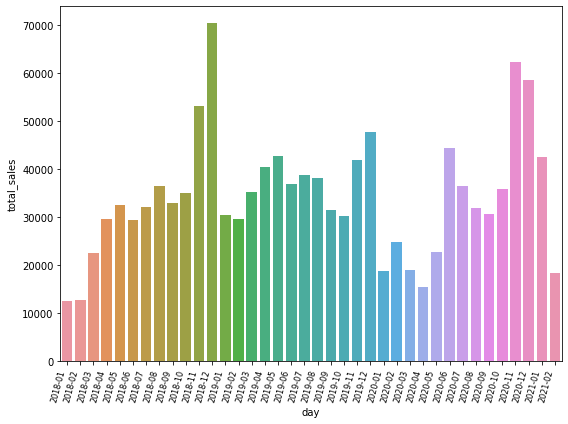

In [26]:
# Total sales per month

per = df_sales_sum1.day.dt.to_period("M")
g = df_sales_sum1.groupby(per)
df_sales_sum2 = g.sum()
df_sales_sum2.reset_index(inplace=True)
df_sales_sum2

show_hist2(['day','total_sales'],df_sales_sum2)

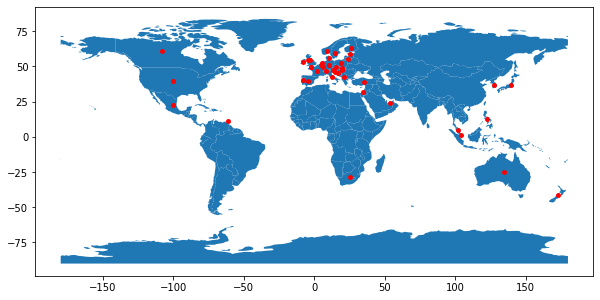

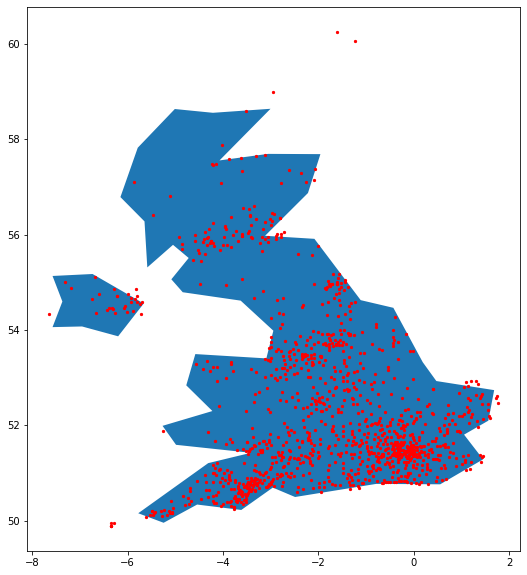

In [ ]:
# WARNING: Can take long time to process

# Plot the billing countries and cities on the maps

list_billing_country = df_sales['billing_country'].unique().tolist()
list_billing_city = df_sales.loc[df_sales['billing_country'] == 'United Kingdom']['billing_city'].unique().tolist()

df_con = get_df_con(list_billing_country, "country")
df_cit = get_df_con(list_billing_city, "city")

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

geometry = [Point(xy) for xy in zip(df_con['lon'], df_con['lat'])]
gdf = GeoDataFrame(df_con, geometry=geometry)   
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

geometry = [Point(xy) for xy in zip(df_cit['lon'], df_cit['lat'])]
gdf = GeoDataFrame(df_cit, geometry=geometry)   
ax = world[world.name == 'United Kingdom']
gdf.plot(ax=ax.plot(figsize=(10, 10)), marker='o', color='red', markersize=5)

# Rec (Customer vs. Product Type/Cat)

## Prepare a dataset

In [ ]:
# Take 3 columns only 
df_sales_simple = df_sales[['customer_id','order_id','product_type']]
df_sales_simple

# Drop nan, drop customer_id 0, make produc_type lowercase
df_sales_clean = df_sales_simple.dropna()
df_sales_clean = df_sales_clean[df_sales_clean['customer_id'] != 0]
df_sales_clean['product_type'] = df_sales_clean['product_type'].apply(lambda x:x.lower())
df_sales_clean

,customer_id,order_id,product_type
1,337253793819,275211943963,sweatshirt
2,337253793819,275211943963,dress
4,185674203163,276031143963,ls t-shirt
5,338242994203,276013449243,hat
7,338237554715,276009484315,placemats
...,...,...,...
71250,1927237763165,3031390617693,underwear
71255,3906919235677,3030729523293,underwear noos
71256,3906919235677,3030729523293,underwear noos
71257,3906919235677,3030729523293,underwear


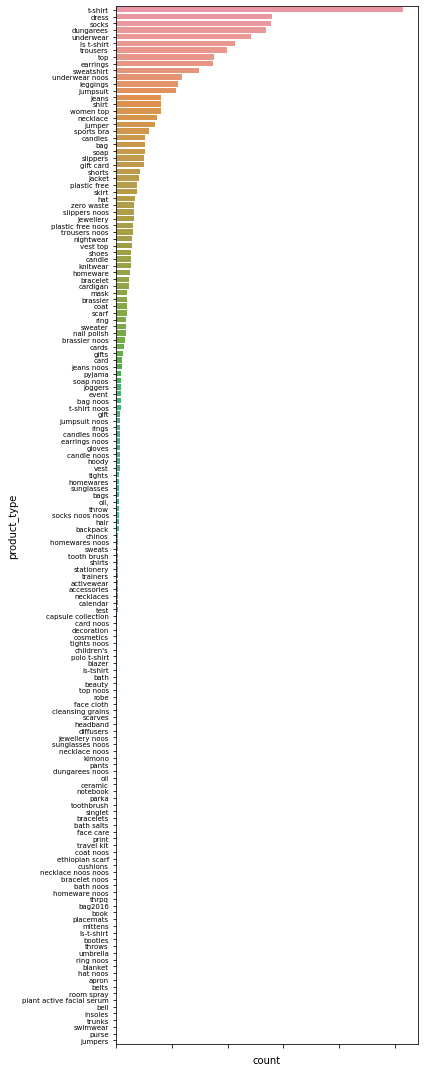

In [ ]:
# Original product type
show_hist1(df_sales_clean["product_type"], df_sales_clean,0)

### without categorize product types (96 categories)
(but only similar name e.g. bracelet and bracelets)

In [ ]:
df_sales_clean["product_cat"] = np.nan
df_sales_clean

df_sales_clean, dictProdCat = create_cat("cat0_product_type.txt", df_sales_clean, 'product_type')
print("Total product category:", len(df_sales_clean['product_cat'].unique()))

# Check if there in a prodcut without category
df_sales_clean[df_sales_clean['product_cat'].isna()]

Total product category: 96


,customer_id,order_id,product_type,product_cat


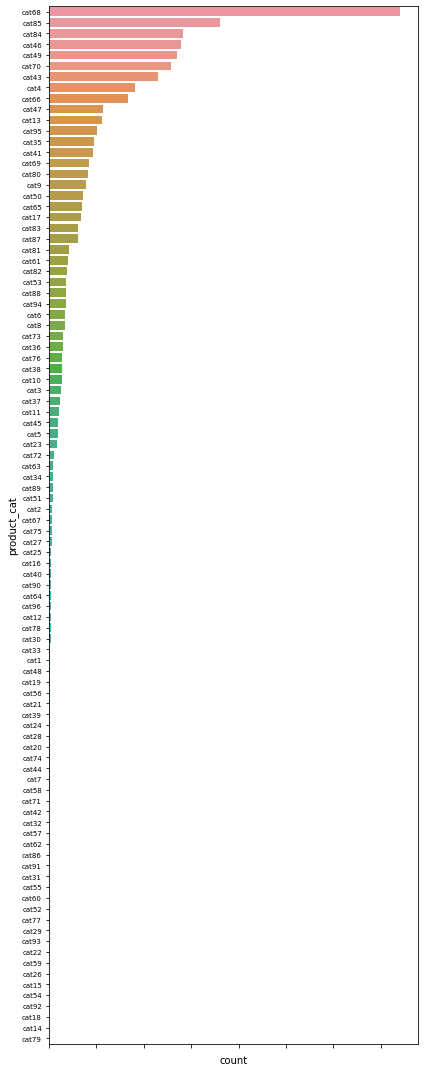

In [ ]:
show_hist1(df_sales_clean["product_cat"], df_sales_clean,0)

In [ ]:
tmpTrTyp, tmpEvTyp = train_test_split(df_sales_clean, test_size=0.2)
print("Total evaluation",len(tmpEvTyp))
print("Total training",len(tmpTrTyp))

Total evaluation 9153
Total training 36612


In [ ]:
df_Tr = pd.DataFrame(tmpTrTyp)

cust_Tr = df_Tr['customer_id'].unique()
typ_Tr = df_Tr['product_cat'].unique()
print('Number of customers in dataset:', len(cust_Tr))
print('Number of products type in dataset:', len(typ_Tr))

df_Tr

Number of customers in dataset: 12505
Number of products type in dataset: 95


,customer_id,order_id,product_type,product_cat
57816,2446387544157,2812363210845,slippers,cat80
29051,1902725791837,1160251244637,t-shirt,cat68
29768,1923184263261,1177348112477,underwear,cat85
17301,694797795421,816018751581,t-shirt,cat68
31777,1989967020125,1232700112989,underwear,cat85
...,...,...,...,...
67103,3854503149661,2945866399837,ls t-shirt,cat68
41771,427525832731,2007346708573,ls t-shirt,cat68
31701,1888917979229,1229874692189,t-shirt,cat68
50867,3406786330717,2452566278237,dress,cat46


In [ ]:
df_Ev = pd.DataFrame(tmpEvTyp)

cust_Ev = df_Ev['customer_id'].unique()
typ_Ev = df_Ev['product_cat'].unique()
print('Number of customers in dataset:', len(cust_Ev))
print('Number of products type in dataset:', len(typ_Ev))

df_Ev

Number of customers in dataset: 5655
Number of products type in dataset: 82


,customer_id,order_id,product_type,product_cat
21583,1199176810589,879368405085,dress,cat46
62680,339839451163,2895219392605,women top,cat70
53439,2818196045917,2530856075357,necklace,cat9
21921,1208791400541,889025396829,shirt,cat69
19364,1156245160029,834577530973,t-shirt,cat68
...,...,...,...,...
45077,2983318224989,2126044921949,dress,cat46
17012,5224301391,815212691549,cards,cat36
50777,481140211739,2451822018653,sweatshirt,cat66
24219,5056247311,1032886976605,shirt,cat69


In [ ]:
# Next is to build a graph

### with  categorize product types 1 (58 categories)

In [ ]:
df_sales_clean["product_cat"] = np.nan
df_sales_clean

df_sales_clean, dictProdCat = create_cat("cat1_product_type.txt", df_sales_clean, 'product_type')

print("Total product category:", len(df_sales_clean['product_cat'].unique()))

# Check if there in a prodcut without category
df_sales_clean[df_sales_clean['product_cat'].isna()]

Total product category: 58


,customer_id,order_id,product_type,product_cat


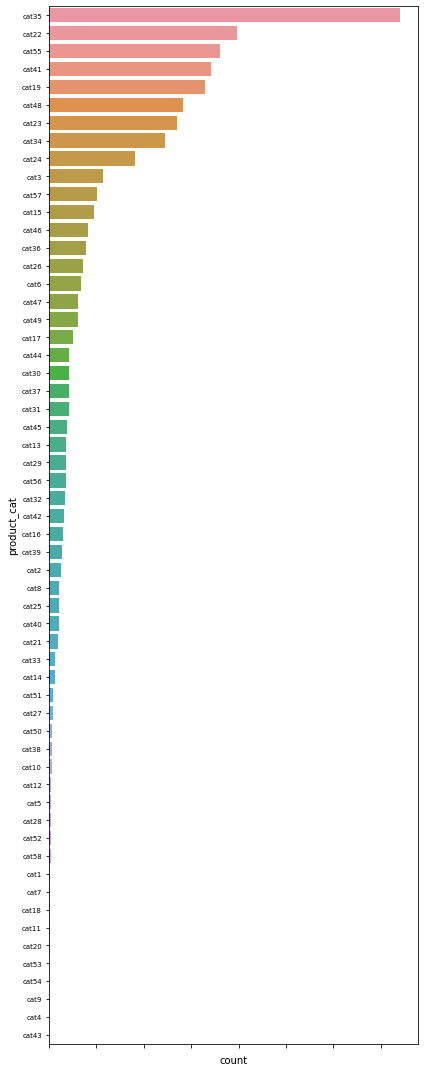

In [ ]:
show_hist1(df_sales_clean["product_cat"], df_sales_clean,0)

In [ ]:
tmpTrTyp, tmpEvTyp = train_test_split(df_sales_clean, test_size=0.2)
print("Total evaluation",len(tmpEvTyp))
print("Total training",len(tmpTrTyp))

Total evaluation 9153
Total training 36612


In [ ]:
df_Tr = pd.DataFrame(tmpTrTyp)

cust_Tr = df_Tr['customer_id'].unique()
typ_Tr = df_Tr['product_cat'].unique()
print('Number of customers in dataset:', len(cust_Tr))
print('Number of products type in dataset:', len(typ_Tr))

df_Tr

Number of customers in dataset: 12460
Number of products type in dataset: 58


,customer_id,order_id,product_type,product_cat
25143,697616564317,1051369537629,underwear,cat55
45380,3027793051741,2164067696733,trousers,cat19
43685,2965328691293,2107352186973,trousers,cat19
65514,3869813506141,2928771727453,nail polish,cat8
586,394721493019,310368239643,tooth brush,cat52
...,...,...,...,...
17960,681107390557,816003842141,sweatshirt,cat34
51259,3415115071581,2463853674589,earrings,cat24
28146,1871638036573,1131839389789,dress,cat22
35475,5658209487,1853257482333,shirt,cat41


In [ ]:
df_Ev = pd.DataFrame(tmpEvTyp)

cust_Ev = df_Ev['customer_id'].unique()
typ_Ev = df_Ev['product_cat'].unique()
print('Number of customers in dataset:', len(cust_Ev))
print('Number of products type in dataset:', len(typ_Ev))

df_Ev

Number of customers in dataset: 5687
Number of products type in dataset: 54


,customer_id,order_id,product_type,product_cat
9443,701026599005,590279180381,socks,cat48
46314,3084731744349,2236386607197,shorts,cat44
52122,3252419330141,2495373312093,jeans,cat19
20414,1178251264093,857365119069,underwear,cat55
30483,1842811994205,1194722066525,top,cat41
...,...,...,...,...
15044,883946717277,665460047965,socks,cat48
2628,594419548253,469277638749,trousers,cat19
9825,688224665693,601131843677,t-shirt,cat35
60968,3375239430237,2872447860829,leggings,cat3


In [ ]:
# Next is to build a graph

### with categorize product types 2 (40 categories)

In [ ]:
df_sales_clean["product_cat"] = np.nan
df_sales_clean

df_sales_clean, dictTypCat = create_cat("cat2_product_type.txt", df_sales_clean, 'product_type')

print("Total product category:", len(df_sales_clean['product_cat'].unique()))

# Check if there in a prodcut without category
df_sales_clean[df_sales_clean['product_cat'].isna()]

Total product category: 40


,customer_id,order_id,product_type,product_cat


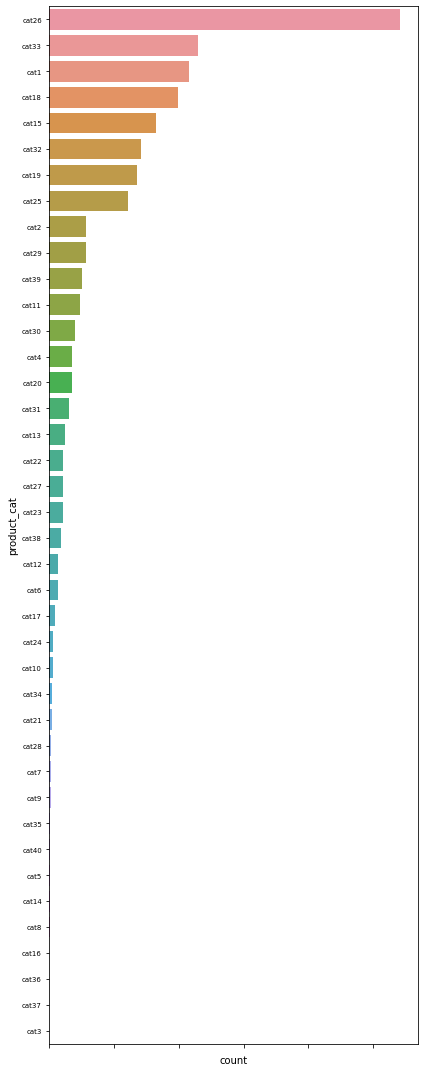

In [ ]:
show_hist1(df_sales_clean["product_cat"], df_sales_clean,0)

In [ ]:
tmpTrTyp, tmpEvTyp = train_test_split(df_sales_clean, test_size=0.2)
print("Total evaluation",len(tmpEvTyp))
print("Total training",len(tmpTrTyp))

Total evaluation 9153
Total training 36612


In [ ]:
df_Tr = pd.DataFrame(tmpTrTyp)

cust_Tr = df_Tr['customer_id'].unique()
typ_Tr = df_Tr['product_cat'].unique()
print('Number of customers in dataset:', len(cust_Tr))
print('Number of products type in dataset:', len(typ_Tr))

df_Tr

Number of customers in dataset: 12517
Number of products type in dataset: 40


,customer_id,order_id,product_type,product_cat
10089,741241454685,605859414109,necklace,cat1
41370,618372497501,1993865691229,jumper,cat25
45439,1927173374045,2164196966493,trousers,cat15
35881,1099117396061,1881361088605,soap,cat31
10194,604974088285,607818809437,sweatshirt,cat25
...,...,...,...,...
20694,623217967197,865310933085,parka,cat23
64091,3854503149661,2908783607901,ls t-shirt,cat26
66533,3877876498525,2940260843613,gift card,cat20
27801,1855365087325,1122628468829,top,cat26


In [ ]:
df_Ev = pd.DataFrame(tmpEvTyp)

cust_Ev = df_Ev['customer_id'].unique()
typ_Ev = df_Ev['product_cat'].unique()
print('Number of customers in dataset:', len(cust_Ev))
print('Number of products type in dataset:', len(typ_Ev))

df_Ev

Number of customers in dataset: 5637
Number of products type in dataset: 40


,customer_id,order_id,product_type,product_cat
66419,3876453023837,2938262454365,gift card,cat20
10798,842046865501,617345843293,sweater,cat25
497,383299158043,299958173723,socks,cat32
63511,3853279428701,2906811367517,necklace,cat1
52492,3028387790941,2508060360797,t-shirt,cat26
...,...,...,...,...
22961,1241841074269,911012102237,underwear,cat33
20737,667725299805,866278211677,sweatshirt,cat25
15116,885412692061,666503479389,homeware,cat22
65483,5448721423,2927961571421,socks,cat32


In [ ]:
# Next is to build a graph

## Build a graph

In [ ]:
df_CustTyp = pd.crosstab(df_Tr['customer_id'],df_Tr['product_cat'])
df_CustTyp

product_cat,cat1,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat2,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat3,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat4,cat40,cat5,cat6,cat7,cat8,cat9
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
267336573,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
313714285,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
953385604,1,0,0,0,1,0,14,0,0,11,2,0,0,0,0,0,0,2,23,0,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1079947012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1242435268,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939751100509,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3939885088861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3940756815965,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Binarize the ratings matrix (indicate only if a customer has purchased a product or not)
df_CustTyp_bin = df_CustTyp.copy()
df_CustTyp_bin[df_CustTyp_bin != 0] = 1
df_CustTyp_bin

product_cat,cat1,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat2,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat3,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat4,cat40,cat5,cat6,cat7,cat8,cat9
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
267336573,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
313714285,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
953385604,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1079947012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1242435268,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939751100509,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3939885088861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3940756815965,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Initialize zeros dataframe for product interactions
#Now, all is about the products
typ_timeBuy, typ_int = mat_nxn(len(typ_Tr), df_CustTyp_bin)

Counting how many times each individual product has been purchased...


In [ ]:
# Contruct the weight matrix
typ_weiBuy = mat_weight(len(typ_Tr), typ_timeBuy, typ_int)
typ_weiBuy

Building weighted product matrix...


array([[0.        , 0.00641711, 0.03310047, ..., 0.00263389, 0.00022578,
        0.00306883],
       [0.00641711, 0.        , 0.00314961, ..., 0.        , 0.        ,
        0.0043956 ],
       [0.03310047, 0.00314961, 0.        , ..., 0.0055991 , 0.00060277,
        0.00390625],
       ...,
       [0.00263389, 0.        , 0.0055991 , ..., 0.        , 0.00492611,
        0.00297619],
       [0.00022578, 0.        , 0.00060277, ..., 0.00492611, 0.        ,
        0.        ],
       [0.00306883, 0.0043956 , 0.00390625, ..., 0.00297619, 0.        ,
        0.        ]])

In [ ]:
k = 0
for i in typ_weiBuy:
  #if k < 1:
    if np.count_nonzero(i)==0: # check if a product doesn't associated with another product
      print(k, i, type(i))
      # if any, mark the row(s) and see their associated labels
    k+=1

22 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] <class 'numpy.ndarray'>


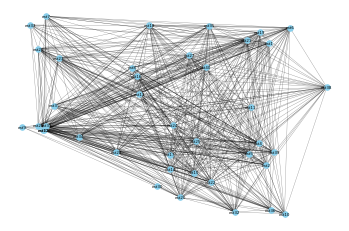

{0: 'cat1',
 1: 'cat25',
 2: 'cat15',
 3: 'cat31',
 4: 'cat26',
 5: 'cat33',
 6: 'cat39',
 7: 'cat19',
 8: 'cat22',
 9: 'cat32',
 10: 'cat27',
 11: 'cat29',
 12: 'cat6',
 13: 'cat11',
 14: 'cat2',
 15: 'cat18',
 16: 'cat17',
 17: 'cat28',
 18: 'cat4',
 19: 'cat20',
 20: 'cat23',
 21: 'cat38',
 22: 'cat30',
 23: 'cat13',
 24: 'cat12',
 25: 'cat21',
 26: 'cat24',
 27: 'cat34',
 28: 'cat10',
 29: 'cat7',
 30: 'cat9',
 31: 'cat40',
 32: 'cat14',
 33: 'cat5',
 34: 'cat8',
 35: 'cat37',
 36: 'cat35',
 37: 'cat16',
 38: 'cat36',
 39: 'cat3'}

In [ ]:
nLabs = df_Tr['product_cat'].unique().tolist()
typCat_Tr_nx = nx.from_numpy_matrix(typ_weiBuy)
pos=nx.random_layout(typCat_Tr_nx)
labCat = {}
for idx, node in enumerate(typCat_Tr_nx.nodes()):
  labCat[node] = nLabs[idx]

save_graph(typCat_Tr_nx, "typCat_Tr", pos, labCat)

labCat

In [ ]:
# Append product type into category graph
k=0
for i in typCat_Tr_nx.nodes():
  #if k<2:
    tmpTy = df_sales_clean[df_sales_clean['product_cat']==labCat[i]]['product_type'].tolist()
    tmpTy = set(tmpTy)
    #print(i, labCat[i], tmpTy)
    typCat_Tr_nx.nodes[i]['prodCat'] = labCat[i]
    typCat_Tr_nx.nodes[i]['prodTy'] = tmpTy
    k+=1

print(typCat_Tr_nx.nodes(data=True))
print(typCat_Tr_nx.edges(data=True))

[(0, {'prodCat': 'cat1', 'prodTy': {'necklace noos', 'necklace', 'sunglasses noos', 'bracelet', 'mask', 'hat noos', 'necklace noos noos', 'ethiopian scarf', 'earrings', 'bracelets', 'bracelet noos', 'hat', 'ring', 'rings', 'jewellery noos', 'earrings noos', 'belts', 'accessories', 'scarf', 'ring noos', 'scarves', 'necklaces', 'jewellery', 'sunglasses', 'headband'}}), (1, {'prodCat': 'cat25', 'prodTy': {'jumper', 'jumpers', 'sweatshirt', 'hoody', 'sweater'}}), (2, {'prodCat': 'cat15', 'prodTy': {'jeans noos', 'jeans', 'trousers', 'chinos', 'trousers noos', 'pants'}}), (3, {'prodCat': 'cat31', 'prodTy': {'soap', 'soap noos'}}), (4, {'prodCat': 'cat26', 'prodTy': {'shirts', 'top', 't-shirt', 'shirt', 'top noos', 'ls-tshirt', 't-shirt noos', 'women top', 'polo t-shirt', 'ls-t-shirt', 'ls t-shirt'}}), (5, {'prodCat': 'cat33', 'prodTy': {'sports bra', 'underwear', 'underwear noos', 'brassier noos', 'singlet', 'brassier'}}), (6, {'prodCat': 'cat39', 'prodTy': {'zero waste', 'plastic free noos

In [ ]:
#Turn into dataframe

typ_prob = mtx_prob(typ_weiBuy, labCat)
typ_prob

,cat1,cat25,cat15,cat31,cat26,cat33,cat39,cat19,cat22,cat32,cat27,cat29,cat6,cat11,cat2,cat18,cat17,cat28,cat4,cat20,cat23,cat38,cat30,cat13,cat12,cat21,cat24,cat34,cat10,cat7,cat9,cat40,cat14,cat5,cat8,cat37,cat35,cat16,cat36,cat3
cat1,0.000000,0.105354,0.543434,0.243538,0.308714,0.025948,0.646852,0.025710,0.122622,0.759816,0.546167,0.303584,0.252865,0.068467,0.300567,0.179534,0.039183,0.628692,1.000000,0.186637,0.053143,0.329462,0.0,0.308339,0.392398,0.664058,0.727784,0.050054,0.040186,0.007410,0.000000,0.184153,0.441745,0.333635,0.003709,0.039981,0.237287,0.043242,0.003707,0.050383
cat25,0.799572,0.000000,0.392441,0.525184,0.674882,0.000000,0.507306,0.343251,0.873773,0.686728,0.567301,0.497405,0.409532,0.555011,1.000000,0.737278,0.000000,0.712000,0.592863,0.575254,0.236433,0.572310,0.0,0.634743,0.460062,0.489366,0.541120,0.000000,0.643928,0.000000,0.000000,0.324198,0.510917,0.642268,0.389375,0.303902,0.369003,0.000000,0.000000,0.547692
cat15,1.000000,0.095153,0.000000,0.383255,0.332815,0.054631,0.466965,0.053314,0.191582,0.529838,0.410542,0.415956,0.484986,0.084577,0.619894,0.269856,0.098568,0.464136,0.641344,0.199743,0.178284,0.432944,0.0,0.338730,0.856762,0.819151,0.613530,0.082906,0.035048,0.018188,0.000000,0.242659,0.845321,0.386919,0.036465,0.103759,0.539942,0.169155,0.018210,0.118012
cat31,1.000000,0.284145,0.855200,0.000000,0.580524,0.000000,0.603660,0.271828,0.369726,0.603251,0.939979,0.452249,0.801535,0.081221,0.828683,0.386600,0.076346,0.598343,0.695595,0.276284,0.296975,0.530814,0.0,0.460159,0.840146,0.748834,0.467754,0.233533,0.087778,0.095622,0.000000,0.439461,0.491435,0.802125,0.192335,0.255676,0.580316,0.406104,0.191788,0.322552
cat26,0.926521,0.266883,0.542811,0.424312,0.000000,0.040027,0.905962,0.116211,0.364537,0.968272,0.785408,0.575108,0.533060,0.181418,0.503022,0.307477,0.104762,0.999654,1.000000,0.469976,0.102939,0.708822,0.0,0.772039,0.505566,0.805844,0.820599,0.247427,0.152078,0.039962,0.000000,0.454021,0.534081,0.600649,0.000000,0.037357,0.205092,0.181418,0.040027,0.108372
cat33,0.160420,0.000000,0.183544,0.000000,0.082453,0.000000,0.072934,0.000000,0.000000,0.047319,0.000000,0.057736,0.209063,1.000000,0.203000,0.000000,0.000000,0.059201,0.069331,0.000000,0.000000,0.079421,0.0,0.000000,0.073604,0.165633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cat39,0.541401,0.055947,0.212396,0.123048,0.252654,0.009874,0.000000,0.013037,0.111351,0.686327,0.436196,0.340189,0.176170,0.028747,0.164389,0.180695,0.059950,0.595066,1.000000,0.161466,0.043922,0.253001,0.0,0.396928,0.198167,0.412449,0.586192,0.044347,0.035650,0.006579,0.000000,0.194892,0.239123,0.272029,0.006586,0.029010,0.124253,0.031942,0.023039,0.028707
cat19,0.186353,0.327824,0.210000,0.479839,0.280660,0.000000,0.112903,0.000000,0.000000,0.164858,0.107644,0.132296,0.117589,0.487705,0.342939,0.147095,0.000000,0.102882,0.080831,0.271071,0.369565,0.090220,0.0,0.203072,0.419014,0.076651,0.171223,0.425000,0.000000,1.000000,0.000000,0.000000,0.204467,0.265033,0.000000,0.580488,0.294554,0.975410,0.000000,0.476000
cat22,0.728371,0.683877,0.618425,0.534849,0.721486,0.000000,0.790248,0.000000,0.000000,1.000000,0.647346,0.317657,0.358006,0.328353,0.701084,0.841422,0.150728,0.740341,0.644996,0.873558,0.580481,0.876460,0.0,0.601409,0.661158,0.536294,0.582536,0.154795,0.000000,0.000000,0.000000,0.150263,0.465271,0.632133,0.419444,0.175713,0.589504,0.492529,0.208824,0.162535
cat32,0.668080,0.079561,0.253169,0.129177,0.283674,0.006730,0.721003,0.019998,0.148025,0.000000,0.463547,0.391587,0.169830,0.035950,0.132893,0.141979,0.051671,0.543954,1.000000,0.191483,0.051383,0.247076,0.0,0.404030,0.234871,0.430409,0.709406,0.051868,0.013259,0.010090,0.003390,0.211417,0.290223,0.245823,0.006733,0.019784,0.159397,0.029414,0.003365,0.042429


In [ ]:
# Read graph
typCat_Tr_nx = nx.read_gml('typCat_Tr.gml')
print(nx.info(typCat_Tr_nx, n=None))
print("Network density:", nx.density(typCat_Tr_nx))
print("Network connected:", nx.number_connected_components(typCat_Tr_nx))

'''
It is fine if the graph is not connected. 
Clustering will automatically group the components.
'''

Name: 
Type: Graph
Number of nodes: 40
Number of edges: 617
Average degree:  30.8500
Network density: 0.791025641025641
Network connected: 2


'\nIt is fine if the graph is not connected. \nClustering will automatically group the components.\n'

40
40
Number of communities: 3


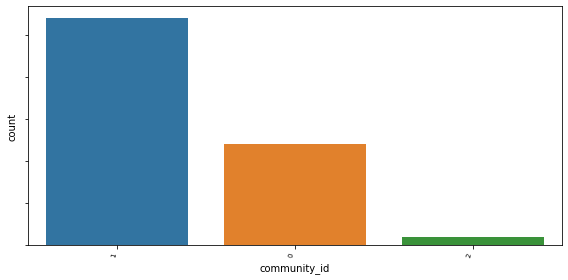

Community with highest nodes: 1 with total nodes: 27


,product_description,community_id
1,cat25,1
2,cat15,1
3,cat31,1
5,cat33,1
7,cat19,1
8,cat22,1
12,cat6,1
13,cat11,1
14,cat2,1
15,cat18,1


In [ ]:
'''
Create a dataframe that contains products and the cluster they belong to.
Now to make a suitable suggestion we only need to select one or more products 
that the customer has purchased (or is thinking of purchasing) and complement 
his final basket of goods.
'''
  
products_communities = mod_Louv(typCat_Tr_nx, labCat)

show_hist1(products_communities["community_id"], products_communities,1)

dictCom = dict(products_communities['community_id'].value_counts())
maxCom = max(dictCom, key=dictCom.get)
maxComN = dictCom[maxCom]
print("Community with highest nodes:", maxCom, "with total nodes:", maxComN)

#Lets take a peek at community 3
products_communities[products_communities['community_id']==maxCom].head(10)

In [ ]:
#Now lets select a hypothetical basket of goods (one or more products) that a 
#customer has already purchased or shown an interest for by clicking on an add 
# or something, and then suggest him relative ones

POI = 'blazer'
for key,val in dictTypCat.items():
  if POI in val: POCat = key
print("Product of", POI, "in", POCat)

theRec = rec_prod([POCat], typ_prob, 10)
for i in theRec:
  print(i,dictTypCat[i])


Product of blazer in cat8
cat36 ['travel kit', 'trunks']
cat37 ['umbrella']
cat22 ['homeware noos', 'homeware', 'homewares noos', 'homewares', 'bell', 'cushions', 'decoration', 'ceramic', 'diffusers', 'room spray', 'placemats']
cat25 ['jumper', 'jumpers', 'sweater', 'sweatshirt', 'hoody']
cat31 ['soap noos', 'soap']
cat18 ['dress', 'jumpsuit noos', 'jumpsuit', 'capsule collection']
cat12 ['card noos', 'card', 'cards']
cat20 ['gift card', 'gift', 'gifts']
cat35 ['tooth brush', 'toothbrush']
cat6 ['beauty', 'cosmetics', 'plant active facial serum', 'nail polish', 'face care', 'face cloth', 'hair']


## Evaluation

In [ ]:
df_Ev

,customer_id,order_id,product_type,product_cat
15367,1081001672797,800152289373,candles,cat11
28963,1898927751261,1156868440157,top,cat26
59732,3094496870493,2856177696861,trousers,cat15
45152,1823108792413,2160412754013,homewares noos,cat22
11430,850786156637,631846830173,necklace,cat1
...,...,...,...,...
8398,686966112349,575702532189,dungarees,cat19
23623,1688130388061,1018780024925,trousers,cat15
46676,1909374091357,2267922202717,t-shirt,cat26
23140,613846155357,916771897437,plastic free,cat39


In [ ]:
dict_eval = df_Ev.groupby('order_id')['product_cat'].apply(list).to_dict()
dict_eval = {key:val for key, val in dict_eval.items() if len(val) > 1}
dict_eval

{276145274907: ['cat2', 'cat26'],
 277554069531: ['cat25', 'cat25'],
 277662990363: ['cat22', 'cat26'],
 278707503131: ['cat33', 'cat33'],
 279993417755: ['cat33', 'cat23'],
 280113283099: ['cat25', 'cat26'],
 280781881371: ['cat26', 'cat26'],
 281590464539: ['cat25', 'cat26'],
 286021156891: ['cat25', 'cat18'],
 288733265947: ['cat25', 'cat26'],
 292643799067: ['cat26', 'cat18'],
 299765399579: ['cat1', 'cat26'],
 299936153627: ['cat18', 'cat26'],
 304200548379: ['cat26', 'cat25'],
 316283256859: ['cat15', 'cat4'],
 319638536219: ['cat15', 'cat15'],
 321113063451: ['cat15', 'cat33', 'cat11'],
 325759238171: ['cat1', 'cat1'],
 327931133979: ['cat4', 'cat33', 'cat33'],
 329729998875: ['cat32', 'cat25'],
 343912775707: ['cat20', 'cat20'],
 344074911771: ['cat26', 'cat26'],
 357537742875: ['cat22', 'cat18', 'cat15'],
 357629526043: ['cat15', 'cat18'],
 364327338011: ['cat1', 'cat26', 'cat12'],
 367272165403: ['cat18', 'cat18'],
 368411901979: ['cat25', 'cat15'],
 385442218011: ['cat1', 'c

In [ ]:
k=0; totPred = 0; totCorr = 0
for key,val in dict_eval.items():
  #if k<50:
    #print(key,val)
    try:
      for i in val:
        buy = i 
        theGT = [x for x in val if x != i]
        #print(buy, theGT)
        theRec = rec_prod([i], typ_prob, 10)
        #print(theRec)
        if theGT[0] in theRec: 
          #print("->found: buy", buy, ",rec", theGT)
          totCorr += 1
        totPred +=1
      #print("-"*50)
      k+=1
    except:pass

print("TotPred:",totPred, "| TotCorr:",totCorr,
      "=>", round(totCorr/totPred,2))

TotPred: 1861 | TotCorr: 604 => 0.32


# Rec (Customer vs. Product Vendor)

## Prepare a dataset

In [ ]:
# Take 3 columns only as simple df
df_sales_simple = df_sales[['customer_id','order_id','product_vendor']]
df_sales_simple

# Drop nan, drop customer_id 0, make produc_type lowercase
df_sales_clean = df_sales_simple.dropna()
df_sales_clean = df_sales_clean[df_sales_clean['customer_id'] != 0]
df_sales_clean['product_vendor'] = df_sales_clean['product_vendor'].apply(lambda x:x.lower())
df_sales_clean

,customer_id,order_id,product_vendor
1,337253793819,275211943963,stanley & stella
2,337253793819,275211943963,komodo
4,185674203163,276031143963,stanley & stella
5,338242994203,276013449243,alison
7,338237554715,276009484315,sabahar
...,...,...,...
71250,1927237763165,3031390617693,people tree
71255,3906919235677,3030729523293,boody
71256,3906919235677,3030729523293,boody
71257,3906919235677,3030729523293,people tree


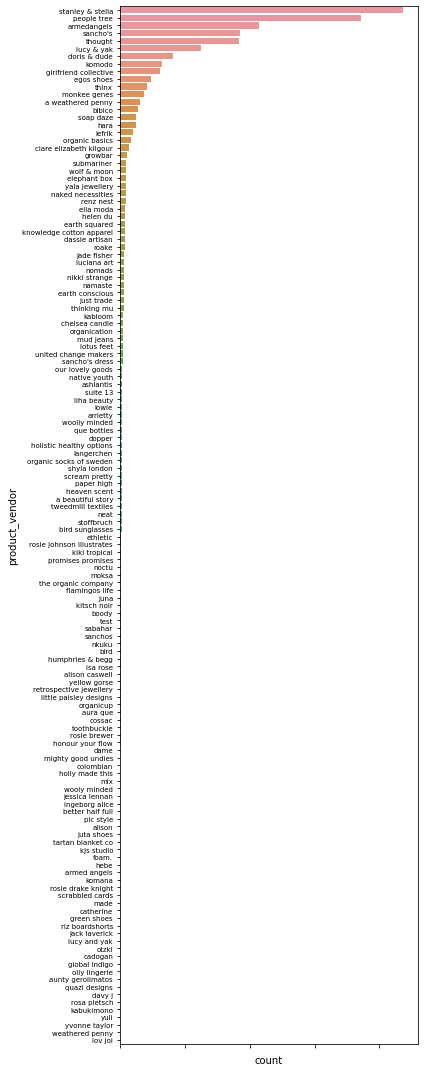

In [ ]:
# Original product type
show_hist1(df_sales_clean["product_vendor"], df_sales_clean,0)

### without categorize product vendor (129 vendors)
(but only similar name e.g. alison and Allison)

In [ ]:
df_sales_clean["product_cat"] = np.nan
df_sales_clean

df_sales_clean, dictVenCat = create_cat("cat_product_ven.txt", df_sales_clean, 'product_vendor')

print("Total vendor category:", len(df_sales_clean['product_cat'].unique()))

# Check if there in a prodcut without category
df_sales_clean[df_sales_clean['product_cat'].isna()]

Total vendor category: 129


,customer_id,order_id,product_vendor,product_cat


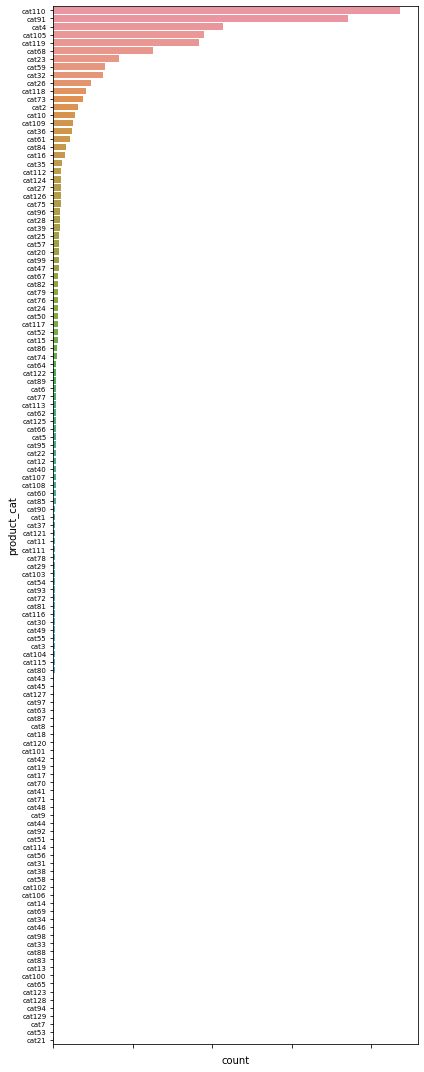

In [ ]:
show_hist1(df_sales_clean["product_cat"], df_sales_clean,0)

In [ ]:
tmpTrVen, tmpEvVen = train_test_split(df_sales_clean, test_size=0.2)
print("Total evaluation",len(tmpEvVen))
print("Total training",len(tmpTrVen))

Total evaluation 9215
Total training 36858


In [ ]:
df_Tr = pd.DataFrame(tmpTrVen)

cust_Tr = df_Tr['customer_id'].unique()
ven_Tr = df_Tr['product_cat'].unique()
print('Number of customers in dataset:', len(cust_Tr))
print('Number of products vendor in dataset:', len(ven_Tr))

df_Tr

Number of customers in dataset: 12496
Number of products vendor in dataset: 127


,customer_id,order_id,product_vendor,product_cat
35519,2694163365981,1856928284765,bibico,cat10
19655,883375800413,844873826397,ethletic,cat29
52010,3429657542749,2492335325277,armedangels,cat4
2679,1451008516,471758078045,lucy & yak,cat68
3338,603266908253,481772765277,lucy & yak,cat68
...,...,...,...,...
22459,1220427317341,900016603229,nikki strange,cat79
41545,2848515719261,2001454137437,sancho's,cat105
48819,3369079636061,2407564542045,stanley & stella,cat110
8475,665279529053,571832500317,stanley & stella,cat110


In [ ]:
df_Ev = pd.DataFrame(tmpEvVen)

cust_Ev = df_Ev['customer_id'].unique()
ven_Ev = df_Ev['product_cat'].unique()
print('Number of customers in dataset:', len(cust_Ev))
print('Number of products vendor in dataset:', len(ven_Ev))

df_Ev

Number of customers in dataset: 5737
Number of products vendor in dataset: 109


,customer_id,order_id,product_vendor,product_cat
66479,3477865562205,2939712274525,roake,cat99
22931,1241935478877,911122890845,people tree,cat91
20191,1175361519709,854118531165,langerchen,cat60
3368,5700419855,481806123101,sancho's,cat105
69426,735169118301,2997333360733,girlfriend collective,cat32
...,...,...,...,...
57823,3775384584285,2812115091549,helen du,cat39
5865,6063499215,522809147485,stanley & stella,cat110
43991,882876153949,2114153709661,stanley & stella,cat110
34515,6004133967,1812391034973,organication,cat86


In [ ]:
# Next is to build a graph

## Build a graph

In [ ]:
df_CustVen = pd.crosstab(df_Tr['customer_id'],df_Tr['product_cat'])
df_CustVen

product_cat,cat1,cat10,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat11,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cat117,cat118,cat119,cat12,cat120,cat121,cat122,cat124,cat125,cat126,cat127,cat129,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat2,...,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat7,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat8,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat9,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
267336573,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313714285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
399541992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
953385604,0,2,0,0,0,0,1,1,0,0,0,0,0,18,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0
964466308,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939751100509,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
3939885088861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3940756815965,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Binarize the ratings matrix (indicate only if a customer has purchased a product or not)
df_CustVen_bin = df_CustVen.copy()
df_CustVen_bin[df_CustVen_bin != 0] = 1
df_CustVen_bin

product_cat,cat1,cat10,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat11,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cat117,cat118,cat119,cat12,cat120,cat121,cat122,cat124,cat125,cat126,cat127,cat129,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat2,...,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat7,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat8,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat9,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
267336573,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313714285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
399541992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
953385604,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
964466308,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939751100509,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3939885088861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3940756815965,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Initialize zeros dataframe for product interactions
#Now, all is about the products
ven_timeBuy, ven_int = mat_nxn(len(ven_Tr), df_CustVen_bin)

Counting how many times each individual product has been purchased...


In [ ]:
ven_weiBuy = mat_weight(len(ven_Tr), ven_timeBuy, ven_int)
ven_weiBuy

Building weighted product matrix...


array([[0.        , 0.00311769, 0.        , ..., 0.0044843 , 0.        ,
        0.        ],
       [0.00311769, 0.        , 0.        , ..., 0.00083195, 0.        ,
        0.00619835],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0044843 , 0.00083195, 0.        , ..., 0.        , 0.        ,
        0.00255102],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00619835, 0.        , ..., 0.00255102, 0.        ,
        0.        ]])

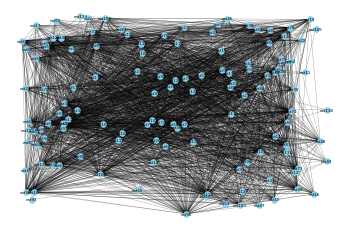

{0: 'cat10',
 1: 'cat29',
 2: 'cat4',
 3: 'cat68',
 4: 'cat119',
 5: 'cat32',
 6: 'cat17',
 7: 'cat110',
 8: 'cat105',
 9: 'cat91',
 10: 'cat2',
 11: 'cat90',
 12: 'cat59',
 13: 'cat36',
 14: 'cat73',
 15: 'cat75',
 16: 'cat107',
 17: 'cat26',
 18: 'cat47',
 19: 'cat113',
 20: 'cat27',
 21: 'cat115',
 22: 'cat124',
 23: 'cat12',
 24: 'cat49',
 25: 'cat23',
 26: 'cat35',
 27: 'cat25',
 28: 'cat61',
 29: 'cat84',
 30: 'cat82',
 31: 'cat118',
 32: 'cat77',
 33: 'cat80',
 34: 'cat109',
 35: 'cat112',
 36: 'cat6',
 37: 'cat16',
 38: 'cat79',
 39: 'cat86',
 40: 'cat114',
 41: 'cat28',
 42: 'cat101',
 43: 'cat96',
 44: 'cat126',
 45: 'cat76',
 46: 'cat20',
 47: 'cat122',
 48: 'cat99',
 49: 'cat85',
 50: 'cat64',
 51: 'cat97',
 52: 'cat52',
 53: 'cat39',
 54: 'cat93',
 55: 'cat8',
 56: 'cat87',
 57: 'cat63',
 58: 'cat24',
 59: 'cat60',
 60: 'cat103',
 61: 'cat74',
 62: 'cat15',
 63: 'cat95',
 64: 'cat22',
 65: 'cat57',
 66: 'cat117',
 67: 'cat104',
 68: 'cat3',
 69: 'cat40',
 70: 'cat67',
 71:

In [ ]:
nLabs = df_Tr['product_cat'].unique().tolist()
venCat_Tr_nx = nx.from_numpy_matrix(ven_weiBuy)
pos=nx.random_layout(venCat_Tr_nx)
labCat = {}
for idx, node in enumerate(venCat_Tr_nx.nodes()):
  labCat[node] = nLabs[idx]

save_graph(venCat_Tr_nx, "venCat_Tr", pos, labCat)

labCat

In [ ]:
# Append product type into category graph
k=0
for i in venCat_Tr_nx.nodes():
  #if k<2:
    tmpVen = df_sales_clean[df_sales_clean['product_cat']==labCat[i]]['product_vendor'].tolist()
    tmpVen = set(tmpVen)
    #print(i, labCat[i], tmpVen)
    venCat_Tr_nx.nodes[i]['prodCat'] = labCat[i]
    venCat_Tr_nx.nodes[i]['prodVen'] = tmpVen
    k+=1

print(venCat_Tr_nx.nodes(data=True))
print(venCat_Tr_nx.edges(data=True))

[(0, {'prodCat': 'cat10', 'prodVen': {'bibico'}}), (1, {'prodCat': 'cat29', 'prodVen': {'ethletic'}}), (2, {'prodCat': 'cat4', 'prodVen': {'armed angels', 'armedangels'}}), (3, {'prodCat': 'cat68', 'prodVen': {'lucy & yak', 'lucy and yak'}}), (4, {'prodCat': 'cat119', 'prodVen': {'thought'}}), (5, {'prodCat': 'cat32', 'prodVen': {'girlfriend collective'}}), (6, {'prodCat': 'cat17', 'prodVen': {'colombian'}}), (7, {'prodCat': 'cat110', 'prodVen': {'stanley & stella'}}), (8, {'prodCat': 'cat105', 'prodVen': {"sancho's", "sancho's dress", 'sanchos'}}), (9, {'prodCat': 'cat91', 'prodVen': {'people tree'}}), (10, {'prodCat': 'cat2', 'prodVen': {'a weathered penny'}}), (11, {'prodCat': 'cat90', 'prodVen': {'paper high'}}), (12, {'prodCat': 'cat59', 'prodVen': {'komodo'}}), (13, {'prodCat': 'cat36', 'prodVen': {'hara'}}), (14, {'prodCat': 'cat73', 'prodVen': {'monkee genes'}}), (15, {'prodCat': 'cat75', 'prodVen': {'naked necessities'}}), (16, {'prodCat': 'cat107', 'prodVen': {'scream pretty'

In [ ]:
#Turn into dataframe

ven_prob = mtx_prob(ven_weiBuy, labCat)
ven_prob

,cat10,cat29,cat4,cat68,cat119,cat32,cat17,cat110,cat105,cat91,cat2,cat90,cat59,cat36,cat73,cat75,cat107,cat26,cat47,cat113,cat27,cat115,cat124,cat12,cat49,cat23,cat35,cat25,cat61,cat84,cat82,cat118,cat77,cat80,cat109,cat112,cat6,cat16,cat79,cat86,...,cat89,cat18,cat102,cat55,cat19,cat81,cat88,cat11,cat1,cat65,cat41,cat78,cat92,cat66,cat9,cat120,cat13,cat58,cat42,cat45,cat70,cat31,cat83,cat14,cat48,cat56,cat51,cat53,cat38,cat33,cat46,cat100,cat129,cat7,cat34,cat98,cat69,cat21,cat94,cat106
cat10,0.000000,0.358535,0.0,0.418182,0.0,0.000000,0.497835,0.363513,0.0,0.000000,1.000000,0.268274,0.529954,0.246592,0.000000,0.203540,0.000000,0.0,0.000000,0.000000,0.000000,0.089009,0.310166,0.000000,0.000000,0.000000,0.000000,0.391156,0.358255,0.320334,0.361635,0.0,0.0,0.0,0.000000,0.280146,0.592784,0.00000,0.0,0.000000,...,0.000000,0.315934,0.0,0.000000,0.614973,0.342602,0.0,0.0,0.000000,0.000000,0.000000,0.152824,0.000000,0.377049,0.685885,0.000000,0.000000,0.649718,0.0,0.000000,0.000000,0.273810,0.0,0.481844,0.000000,0.000000,0.000000,0.668605,0.000000,0.000000,0.871212,0.207083,0.000000,0.0,0.0,0.000000,0.000000,0.515695,0.0,0.000000
cat29,0.168438,0.000000,0.0,0.129250,0.0,0.218377,0.089300,0.709298,0.0,0.044947,0.044687,0.596320,0.090345,0.949854,0.088423,0.279930,0.129044,0.0,0.046177,0.132418,0.200544,0.547165,0.922336,0.041273,0.046776,0.088063,0.125643,0.517165,0.249353,0.201893,0.166620,0.0,0.0,0.0,0.158785,0.510251,0.046058,0.04598,0.0,0.366530,...,0.091030,0.201141,0.0,0.042878,0.199655,0.595682,0.0,0.0,0.046615,0.046494,0.043817,0.500246,0.236440,0.272003,0.182276,0.124581,0.133289,0.214675,0.0,0.045022,0.090345,0.154472,0.0,0.414363,0.127521,0.233208,0.090954,0.046939,0.159606,0.093149,0.086929,0.975489,0.093310,0.0,0.0,0.131026,0.356846,0.044947,0.0,0.334875
cat4,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.033229,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.909871,0.000000,0.000000,0.00000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
cat68,0.358182,0.235646,0.0,0.000000,0.0,0.000000,0.000000,0.156705,0.0,0.000000,0.000000,0.313445,0.000000,0.090923,0.000000,0.367537,0.000000,0.0,0.608025,0.000000,0.000000,0.155978,0.082238,0.327243,0.000000,0.000000,0.349291,0.352415,0.337329,0.000000,0.681661,0.0,0.0,0.0,0.279037,0.373106,0.000000,0.00000,0.0,0.245636,...,0.000000,0.294030,0.0,0.390873,0.000000,0.148866,0.0,0.0,0.000000,0.000000,0.437778,0.133469,0.000000,0.847676,0.415612,0.336177,0.000000,0.588645,0.0,0.000000,0.000000,0.251918,0.0,0.143377,0.374525,0.515707,0.000000,0.000000,0.284682,0.000000,0.419149,0.118764,0.000000,0.0,0.0,0.000000,0.194664,0.000000,0.0,0.221847
cat119,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.019612,0.0,0.000000,1.000000,0.000000,0.000000,0.013160,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.017972,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.061810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012887,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
# Read graph
venCat_Tr_nx = nx.read_gml('venCat_Tr.gml')
print(nx.info(venCat_Tr_nx, n=None))
print("Network density:", nx.density(venCat_Tr_nx))
print("Network connected:", nx.number_connected_components(venCat_Tr_nx))

'''
It is fine if the graph is not connected. 
Clustering will automatically group the components.
'''

Name: 
Type: Graph
Number of nodes: 127
Number of edges: 2861
Average degree:  45.0551
Network density: 0.35758030246219225
Network connected: 1


'\nIt is fine if the graph is not connected. \nClustering will automatically group the components.\n'

127
127
Number of communities: 5


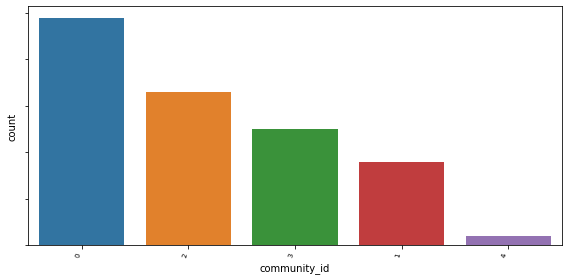

Community with highest nodes: 0 with total nodes: 49


,product_description,community_id
0,cat10,0
2,cat4,0
3,cat68,0
4,cat119,0
6,cat17,0
10,cat2,0
15,cat75,0
18,cat47,0
23,cat12,0
28,cat61,0


In [ ]:
'''
Create a dataframe that contains products and the cluster they belong to.
Now to make a suitable suggestion we only need to select one or more products 
that the customer has purchased (or is thinking of purchasing) and complement 
his final basket of goods.
'''
 
products_communities = mod_Louv(venCat_Tr_nx, labCat)

show_hist1(products_communities["community_id"], products_communities,1)

dictCom = dict(products_communities['community_id'].value_counts())
maxCom = max(dictCom, key=dictCom.get)
maxComN = dictCom[maxCom]
print("Community with highest nodes:", maxCom, "with total nodes:", maxComN)

#Lets take a peek at community 3
products_communities[products_communities['community_id']==maxCom].head(10)

In [ ]:
#Now lets select a hypothetical basket of goods (one or more products) that a 
#customer has already purchased or shown an interest for by clicking on an add 
# or something, and then suggest him relative ones

POI = 'bibico'
for key,val in dictVenCat.items():
  if POI in val: POCat = key
print("Product of", POI, "in", POCat)

theRec = rec_prod([POCat], ven_prob, 10)
for i in theRec:
  print(i,dictVenCat[i])

Product of bibico in cat10
cat44 ['ingeborg alice']
cat30 ['flamingos life']
cat21 ['davy j']
cat2 ['a weathered penny']
cat114 ['tartan blanket co']
cat19 ['dame']
cat122 ['united change makers']
cat17 ['colombian']
cat85 ['organic socks of sweden']
cat61 ['lefrik']


## Evaluation

In [ ]:
df_Ev

,customer_id,order_id,product_vendor,product_cat
66479,3477865562205,2939712274525,roake,cat99
22931,1241935478877,911122890845,people tree,cat91
20191,1175361519709,854118531165,langerchen,cat60
3368,5700419855,481806123101,sancho's,cat105
69426,735169118301,2997333360733,girlfriend collective,cat32
...,...,...,...,...
57823,3775384584285,2812115091549,helen du,cat39
5865,6063499215,522809147485,stanley & stella,cat110
43991,882876153949,2114153709661,stanley & stella,cat110
34515,6004133967,1812391034973,organication,cat86


In [ ]:
dict_eval = df_Ev.groupby('order_id')['product_cat'].apply(list).to_dict()
dict_eval = {key:val for key, val in dict_eval.items() if len(val) > 1}
dict_eval

{278691512347: ['cat110', 'cat105'],
 278707503131: ['cat119', 'cat84', 'cat119'],
 279996923931: ['cat110', 'cat119'],
 280781881371: ['cat10', 'cat10', 'cat10'],
 281415254043: ['cat110', 'cat13'],
 281433145371: ['cat91', 'cat91'],
 284850815003: ['cat110', 'cat110'],
 287519440923: ['cat82', 'cat91'],
 292643799067: ['cat110', 'cat110'],
 298401464347: ['cat119', 'cat119', 'cat110'],
 304125018139: ['cat110', 'cat91'],
 305504550939: ['cat79', 'cat79'],
 306560073755: ['cat105', 'cat105'],
 321467908123: ['cat105', 'cat10'],
 331072995355: ['cat110', 'cat4'],
 357454708763: ['cat109', 'cat109'],
 364327338011: ['cat119', 'cat4'],
 368411901979: ['cat119', 'cat74'],
 369052811291: ['cat4', 'cat107'],
 391038435355: ['cat110', 'cat119'],
 398012579867: ['cat91', 'cat91'],
 416923549723: ['cat110', 'cat119'],
 428252856347: ['cat4', 'cat57', 'cat73'],
 435643940891: ['cat112', 'cat119'],
 463497101405: ['cat37', 'cat91'],
 464056320093: ['cat4', 'cat110', 'cat119'],
 464797237341: ['c

In [ ]:
k=0; totPred = 0; totCorr = 0
for key,val in dict_eval.items():
  #if k<50:
    #print(key,val)
    try:
      for i in val:
        buy = i 
        theGT = [x for x in val if x != i]
        #print(buy, theGT)
        theRec = rec_prod([i], ven_prob, 10)
        #print(theRec)
        if theGT[0] in theRec: 
          #print("->found: buy", buy, ",rec", theGT)
          totCorr += 1
        totPred +=1
      #print("-"*50)
      k+=1
    except:pass

print("TotPred:",totPred, "| TotCorr:",totCorr,
      "=>", round(totCorr/totPred,2))

TotPred: 1847 | TotCorr: 92 => 0.05


# Rec (Customer vs. Product Id)

## Prepare a dataset

In [ ]:
# Take 3 columns only as simple df
df_sales_simple = df_sales[['customer_id','order_id','product_id']]
df_sales_simple

# Drop nan, drop customer_id 0, drop product_id 0
df_sales_clean = df_sales_simple.dropna()
df_sales_clean = df_sales_clean[df_sales_clean['customer_id'] != 0]
df_sales_clean = df_sales_clean[df_sales_clean['product_id'] != 0]
df_sales_clean

,customer_id,order_id,product_id
1,337253793819,275211943963,11606814671
2,337253793819,275211943963,10461963983
4,185674203163,276031143963,89183715355
5,338242994203,276013449243,265754771483
7,338237554715,276009484315,413081370651
...,...,...,...
71250,1927237763165,3031390617693,4399595028573
71255,3906919235677,3030729523293,4839341457501
71256,3906919235677,3030729523293,4839341555805
71257,3906919235677,3030729523293,1296876470365


In [ ]:
tmpTrId, tmpEvId = train_test_split(df_sales_clean, test_size=0.3)
print("Total evaluation",len(tmpEvId))
print("Total training",len(tmpTrId))

Total evaluation 13508
Total training 31517


In [ ]:
df_Tr = pd.DataFrame(tmpTrId)

cust_Tr = df_Tr['customer_id'].unique()
id_Tr = df_Tr['product_id'].unique()
print('Number of customers in dataset:', len(cust_Tr))
print('Number of products in dataset:', len(id_Tr))

df_Tr

Number of customers in dataset: 11626
Number of products in dataset: 2844


,customer_id,order_id,product_id
45640,1817382846557,2173512941661,4432167108701
3408,604094660701,482729361501,682811654171
68019,3405329858653,2962043043933,4775481311325
42477,1874702336093,2035910574173,4501292941405
33712,2449202282589,1710451392605,3657978380381
...,...,...,...
36161,2728011661405,1885611098205,4271491022941
16330,1102293925981,809680306269,1411352330333
54035,4895225412,2538982965341,4606738464861
62002,3831901356125,2883832447069,1933687521373


In [ ]:
df_Ev = pd.DataFrame(tmpEvId)

cust_Ev = df_Ev['customer_id'].unique()
id_Ev = df_Ev['product_id'].unique()
print('Number of customers in dataset:', len(cust_Ev))
print('Number of products type in dataset:', len(id_Ev))

df_Ev

Number of customers in dataset: 7322
Number of products type in dataset: 2399


,customer_id,order_id,product_id
1589,494504869915,414160683035,628927889435
14455,882907349085,664332435549,1482471997533
3645,1913774020,489108078685,748564775005
28701,290427895835,1146881638493,3647618056285
7114,6218685839,559146926173,1307696758877
...,...,...,...
45844,1813435383901,2179662413917,3663007154269
66180,2809854591069,2934627795037,4783597518941
22647,881729994845,904192360541,1973769961565
61771,3830804283485,2882235301981,4806821445725


In [ ]:
# Next is to build a graph

## Build a graph

In [ ]:
df_CustId = pd.crosstab(df_Tr['customer_id'],df_Tr['product_id'])
df_CustId

product_id,423775944,423777436,423780560,450013104,450013680,450014076,879553284,880702788,1432254468,1613439620,3824501572,4130470532,4130475972,4653256132,4654868676,4655038980,4655052292,6450964228,6455427716,9079730756,9108512068,9178562628,9185863300,9185959172,9186249028,9187210628,9201785284,9230852804,9230893828,9230895108,9250880452,9250968132,9332052740,9346978180,9435046084,9518414148,9523757444,9531589380,9531595780,9531916036,...,4832854278237,4834168111197,4834169421917,4834174795869,4835293364317,4835321249885,4835321806941,4837472370781,4837472436317,4837472665693,4837496389725,4838064619613,4838064816221,4838065307741,4838068093021,4839340081245,4839340146781,4839340310621,4839340474461,4839340539997,4839341359197,4839341457501,4839341555805,4839341686877,4839353942109,4839607304285,4839607828573,4839610351709,4839620280413,4839620608093,4839944585309,4841075572829,4841077997661,4841097298013,4841100509277,4841101787229,4841103294557,4841351118941,4841351741533,4841352396893
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
267336573,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313714285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
399541992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
953385604,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1079947012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939491709021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3939751100509,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3939885088861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Binarize the ratings matrix (indicate only if a customer has purchased a product or not)
df_CustId_bin = df_CustId.copy()
df_CustId_bin[df_CustId_bin != 0] = 1
df_CustId_bin

product_id,423775944,423777436,423780560,450013104,450013680,450014076,879553284,880702788,1432254468,1613439620,3824501572,4130470532,4130475972,4653256132,4654868676,4655038980,4655052292,6450964228,6455427716,9079730756,9108512068,9178562628,9185863300,9185959172,9186249028,9187210628,9201785284,9230852804,9230893828,9230895108,9250880452,9250968132,9332052740,9346978180,9435046084,9518414148,9523757444,9531589380,9531595780,9531916036,...,4832854278237,4834168111197,4834169421917,4834174795869,4835293364317,4835321249885,4835321806941,4837472370781,4837472436317,4837472665693,4837496389725,4838064619613,4838064816221,4838065307741,4838068093021,4839340081245,4839340146781,4839340310621,4839340474461,4839340539997,4839341359197,4839341457501,4839341555805,4839341686877,4839353942109,4839607304285,4839607828573,4839610351709,4839620280413,4839620608093,4839944585309,4841075572829,4841077997661,4841097298013,4841100509277,4841101787229,4841103294557,4841351118941,4841351741533,4841352396893
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
267336573,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313714285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
399541992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
953385604,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1079947012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939491709021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3939751100509,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3939885088861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# WARNING: Can take long time to process

#Initialize zeros dataframe for product interactions
#Now, all is about the products
id_timeBuy, id_int = mat_nxn(len(id_Tr), df_CustId_bin)

Counting how many times each individual product has been purchased...


In [ ]:
id_weiBuy = mat_weight(len(id_Tr), id_timeBuy, id_int)
id_weiBuy

Building weighted product matrix...


array([[0.        , 0.        , 0.00840336, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00840336, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

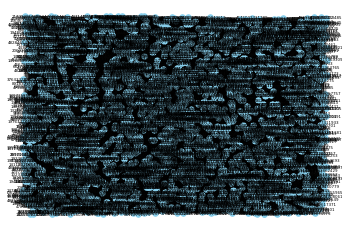

{0: 4432167108701,
 1: 682811654171,
 2: 4775481311325,
 3: 4501292941405,
 4: 3657978380381,
 5: 1971118604381,
 6: 3658911252573,
 7: 1297347346525,
 8: 4824440766557,
 9: 4730447560797,
 10: 4805046632541,
 11: 2087471153245,
 12: 3657976545373,
 13: 3793625874525,
 14: 3658911285341,
 15: 3546978648157,
 16: 4796801450077,
 17: 11867662927,
 18: 4274272108637,
 19: 293494259739,
 20: 3663007318109,
 21: 1580209045597,
 22: 587393761307,
 23: 628927889435,
 24: 4606738464861,
 25: 3732834418781,
 26: 753232642141,
 27: 4773351915613,
 28: 3664628088925,
 29: 1507819192413,
 30: 753425416285,
 31: 1973769699421,
 32: 4545201143901,
 33: 324468932635,
 34: 4397402882141,
 35: 3658905976925,
 36: 4399796879453,
 37: 1377838399581,
 38: 1413590646877,
 39: 4808057127005,
 40: 4754326323293,
 41: 1412228022365,
 42: 4544050823261,
 43: 4678231195741,
 44: 1297347313757,
 45: 4756968439901,
 46: 665809453083,
 47: 716504498203,
 48: 4779230167133,
 49: 3662228979805,
 50: 11860536911,
 51

In [ ]:
nLabs = df_Tr['product_id'].unique().tolist()
id_Tr_nx = nx.from_numpy_matrix(id_weiBuy)
pos=nx.random_layout(id_Tr_nx)
lab = {}
for idx, node in enumerate(id_Tr_nx.nodes()):
  lab[node] = nLabs[idx]

save_graph(id_Tr_nx, "id_Tr", pos, lab)

lab

In [ ]:
# Read graph
id_Tr_nx = nx.read_gml('id_Tr.gml')
print(nx.info(id_Tr_nx, n=None))
print("Network density:", nx.density(id_Tr_nx))
print("Network connected:", nx.number_connected_components(id_Tr_nx))

'''
It is fine if the graph is not connected. 
Clustering will automatically group the components.
'''

Name: 
Type: Graph
Number of nodes: 2844
Number of edges: 79925
Average degree:  56.2060
Network density: 0.019769978128727356
Network connected: 102


'\nIt is fine if the graph is not connected. \nClustering will automatically group the components.\n'

In [ ]:
#Turn into dataframe

id_prob = mtx_prob(id_weiBuy, lab)
id_prob

,4432167108701,682811654171,4775481311325,4501292941405,3657978380381,1971118604381,3658911252573,1297347346525,4824440766557,4730447560797,4805046632541,2087471153245,3657976545373,3793625874525,3658911285341,3546978648157,4796801450077,11867662927,4274272108637,293494259739,3663007318109,1580209045597,587393761307,628927889435,4606738464861,3732834418781,753232642141,4773351915613,3664628088925,1507819192413,753425416285,1973769699421,4545201143901,324468932635,4397402882141,3658905976925,4399796879453,1377838399581,1413590646877,4808057127005,...,1297347870813,1499577942109,4841075572829,10153855311,11533836879,1413590515805,1973210284125,11798542287,4782045954141,4773351227485,683274436635,1389361725533,1384060977245,3516761079901,10029327951,4837472370781,3663066267741,4826120618077,4823309025373,1305432621149,3523098968157,3608536088669,277127987227,1501819633757,3675443888221,357933121563,4839620280413,3662191951965,4545003421789,295615266843,3675443789917,1976009392221,324567236635,4599112138845,4839353942109,4808062697565,4779200184413,3512493342813,11821383567,11337821135
4432167108701,0.000000,0.0,0.159664,0.0,1.0,0.558824,0.202128,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.316667,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
682811654171,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.289474,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4775481311325,0.676471,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.0,0.0,0.55137,0.0,0.0,0.0,0.0,0.0,0.0,0.633858,0.221154,0.0,0.0,0.55137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.71875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4501292941405,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3657978380381,1.000000,0.0,0.000000,0.0,0.0,0.950000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808062697565,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4779200184413,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

2844
2844
Number of communities: 124


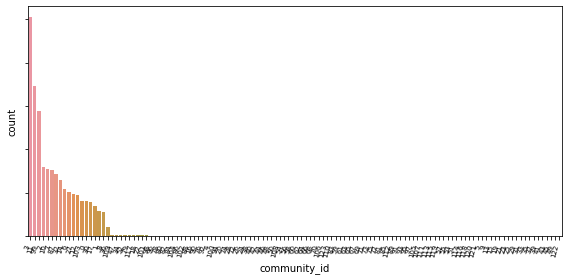

Community with highest nodes: 3 with total nodes: 504


,product_description,community_id
3,4501292941405,3
11,2087471153245,3
32,4545201143901,3
72,4756976435293,3
78,4667882963037,3
90,3663007285341,3
157,2056174796893,3
170,603368718363,3
224,4397402783837,3
230,1933638402141,3


In [ ]:
'''
Create a dataframe that contains products and the cluster they belong to.
Now to make a suitable suggestion we only need to select one or more products 
that the customer has purchased (or is thinking of purchasing) and complement 
his final basket of goods.
'''
  
products_communities = mod_Louv(id_Tr_nx, lab)

show_hist1(products_communities["community_id"], products_communities,1)

dictCom = dict(products_communities['community_id'].value_counts())
maxCom = max(dictCom, key=dictCom.get)
maxComN = dictCom[maxCom]
print("Community with highest nodes:", maxCom, "with total nodes:", maxComN)

#Lets take a peek at community 3
products_communities[products_communities['community_id']==maxCom].head(10)

## Evaluation

In [ ]:
df_Ev

,customer_id,order_id,product_id
1589,494504869915,414160683035,628927889435
14455,882907349085,664332435549,1482471997533
3645,1913774020,489108078685,748564775005
28701,290427895835,1146881638493,3647618056285
7114,6218685839,559146926173,1307696758877
...,...,...,...
45844,1813435383901,2179662413917,3663007154269
66180,2809854591069,2934627795037,4783597518941
22647,881729994845,904192360541,1973769961565
61771,3830804283485,2882235301981,4806821445725


In [ ]:
dict_eval = df_Ev.groupby('order_id')['product_id'].apply(list).to_dict()
dict_eval = {key:val for key, val in dict_eval.items() if len(val) > 1}

In [ ]:
k=0; totPred = 0; totCorr = 0
for key,val in dict_eval.items():
  #if k<50:
    #print(key,val)
    try:
      for i in val:
        buy = i 
        theGT = [x for x in val if x != i]
        #print(buy, theGT)
        theRec = rec_prod([i], id_prob, 10)
        #print(theRec)
        if theGT[0] in theRec: 
          #print("->found: buy", buy, ",rec", theGT)
          totCorr += 1
        totPred +=1
      #print("-"*50)
      k+=1
    except:pass

print("TotPred:",totPred, "| TotCorr:",totCorr,
      "=>", round(totCorr/totPred,2))

TotPred: 4967 | TotCorr: 20 => 0.0


# Rec with LightFM

In [ ]:
# Take several columns only as simple df
df_sales_simple = df_sales[['day','customer_id',
                            'order_id','net_sales',
                            'product_id','product_type','product_vendor','variant_sku','net_quantity']]
df_sales_simple

# Drop nan, drop customer_id 0, drop product_id 0, make produc_type lowercase
df_sales_clean = df_sales_simple.dropna()
df_sales_clean = df_sales_clean[df_sales_clean['customer_id'] != 0]
df_sales_clean = df_sales_clean[df_sales_clean['product_id'] != 0]
df_sales_clean['product_type'] = df_sales_clean['product_type'].apply(lambda x:x.lower())
df_sales_clean

,day,customer_id,order_id,net_sales,product_id,product_type,product_vendor,variant_sku,net_quantity
1,2018-01-01,337253793819,275211943963,11.33,11606814671,sweatshirt,Stanley & Stella,STSW349C508,1
2,2018-01-01,337253793819,275211943963,35.00,10461963983,dress,Komodo,C1 HF 38 FLORAL PRINT HEMP-4,1
4,2018-01-02,185674203163,276031143963,16.20,89183715355,ls t-shirt,Stanley & Stella,STTW033C002110,1
9,2018-01-02,338237554715,276009484315,2.25,47295561755,cards,Little Paisley Designs,LPD105,1
12,2018-01-02,338467979291,276299218971,12.50,290227257371,cards,Nikki Strange,73015,1
...,...,...,...,...,...,...,...,...,...
71250,2021-02-16,1927237763165,3031390617693,18.33,4399595028573,underwear,People Tree,PPT-X380UY.BK1,1
71255,2021-02-16,3906919235677,3030729523293,12.71,4839341457501,underwear noos,Boody,BOODY-BRLM,1
71256,2021-02-16,3906919235677,3030729523293,12.72,4839341555805,underwear noos,Boody,BOODY-BRN4,1
71257,2021-02-16,3906919235677,3030729523293,16.66,1296876470365,underwear,People Tree,PPT-U377UV.BK1,1


In [ ]:
df_sales_clean, dictTypCat = create_cat("cat2_product_type.txt", df_sales_clean, 'product_type')

print("Total product category:", len(df_sales_clean['product_cat'].unique()))

# Check if there in a prodcut without category
df_sales_clean[df_sales_clean['product_cat'].isna()]

Total product category: 40


,day,customer_id,order_id,net_sales,product_id,product_type,product_vendor,variant_sku,net_quantity,product_cat


In [ ]:
print("total product_id ori:",df_sales_clean['product_id'].nunique())

list_Pmore2C = get_prodMore2Cust(df_sales_clean)
print("total product_id with multiple customer_id:",len(list_Pmore2C))

total product_id ori: 2772
total product_id with multiple customer_id: 2576


In [ ]:
# Here, we only consider the products that have been bought by at least 2 customers
# The reason is so at least one customer from each product will be in test dataset

df_DL = df_sales_clean[df_sales_clean['product_id'].isin(list_Pmore2C)].reset_index()
print("total unique users:", df_DL['customer_id'].nunique())
print("total unique product:", df_DL['product_id'].nunique())
df_DL

total unique users: 13083
total unique product: 2576


,index,day,customer_id,order_id,net_sales,product_id,product_type,product_vendor,variant_sku,net_quantity,product_cat
0,1,2018-01-01,337253793819,275211943963,11.33,11606814671,sweatshirt,Stanley & Stella,STSW349C508,1,cat25
1,2,2018-01-01,337253793819,275211943963,35.00,10461963983,dress,Komodo,C1 HF 38 FLORAL PRINT HEMP-4,1,cat18
2,4,2018-01-02,185674203163,276031143963,16.20,89183715355,ls t-shirt,Stanley & Stella,STTW033C002110,1,cat26
3,9,2018-01-02,338237554715,276009484315,2.25,47295561755,cards,Little Paisley Designs,LPD105,1,cat12
4,12,2018-01-02,338467979291,276299218971,12.50,290227257371,cards,Nikki Strange,73015,1,cat12
...,...,...,...,...,...,...,...,...,...,...,...
42791,71250,2021-02-16,1927237763165,3031390617693,18.33,4399595028573,underwear,People Tree,PPT-X380UY.BK1,1,cat33
42792,71255,2021-02-16,3906919235677,3030729523293,12.71,4839341457501,underwear noos,Boody,BOODY-BRLM,1,cat33
42793,71256,2021-02-16,3906919235677,3030729523293,12.72,4839341555805,underwear noos,Boody,BOODY-BRN4,1,cat33
42794,71257,2021-02-16,3906919235677,3030729523293,16.66,1296876470365,underwear,People Tree,PPT-U377UV.BK1,1,cat33


In [ ]:
# Create map Usr->Idx and Idx->Usr

map_Usr2Idx, map_Idx2Usr = create_map(df_DL, 'customer_id')
print("map_Usr2Idx:",len(map_Usr2Idx))
print("map_Idx2Usr:",len(map_Idx2Usr))

Total customer_id : 13083
map_Usr2Idx: 13083
map_Idx2Usr: 13083


In [ ]:
# Create map Pro->Idx and Idx->Pro

map_Pro2Idx, map_Idx2Pro = create_map(df_DL, 'product_id')
print("map_Pro2Idx:",len(map_Pro2Idx))
print("map_Idx2Pro:",len(map_Idx2Pro))

Total product_id : 2576
map_Pro2Idx: 2576
map_Idx2Pro: 2576


### Define the products features
There are 4 product's features we consider:

*   Product type
*   Product vendor
*   Variant SKU
*   Product category



In [ ]:
# Create map ProTyp->Idx and Idx->ProTyp
# Feature product_type
df_prodFeat_typ = df_DL[['product_id','product_type']]
map_prodTyp2Idx, map_Idx2prodTyp = create_map(
    df_prodFeat_typ, 'product_type')
print("map_ProTyp2Idx:",len(map_prodTyp2Idx))
print("map_Idx2ProTyp:",len(map_Idx2prodTyp))
#df_prodFeat_typ

print("-"*75)

# Create map ProVen->Idx and Idx->ProVen
# Feature product_vendor
df_prodFeat_ven = df_DL[['product_id','product_vendor']]
map_prodVen2Idx, map_Idx2prodVen = create_map(
    df_prodFeat_ven, 'product_vendor')
print("map_ProVen2Idx:",len(map_prodVen2Idx))
print("map_Idx2ProVen:",len(map_Idx2prodVen))
#df_prodFeat_ven

print("-"*75)

# Create map ProSku->Idx and Idx->ProSku
# Feature product_sku
df_prodFeat_sku = df_DL[['product_id','variant_sku']]
map_prodSku2Idx, map_Idx2prodSku = create_map(
    df_prodFeat_sku, 'variant_sku')
print("map_ProSku2Idx:",len(map_prodSku2Idx))
print("map_Idx2ProSku:",len(map_Idx2prodSku))
#df_prodFeat_sku

print("-"*75)

# Create map ProCat->Idx and Idx->ProCat
# Feature product_cat
df_prodFeat_cat = df_DL[['product_id','product_cat']]
map_prodCat2Idx, map_Idx2prodCat = create_map(
    df_prodFeat_cat, 'product_cat')
print("map_ProCat2Idx:",len(map_prodCat2Idx))
print("map_Idx2ProCat:",len(map_Idx2prodCat))
#df_prodFeat_cat

Total product_type : 134
map_ProTyp2Idx: 134
map_Idx2ProTyp: 134
---------------------------------------------------------------------------
Total product_vendor : 110
map_ProVen2Idx: 110
map_Idx2ProVen: 110
---------------------------------------------------------------------------
Total variant_sku : 2827
map_ProSku2Idx: 2827
map_Idx2ProSku: 2827
---------------------------------------------------------------------------
Total product_cat : 40
map_ProCat2Idx: 40
map_Idx2ProCat: 40


In [ ]:
# Create Matrix product_type Feature/metadata/embedding
matCoo_ProTypFeat = build_cooMat(df_DL, map_Pro2Idx, map_prodTyp2Idx, 
                                 'product_id', 'product_type', "way1")
matCoo_ProTypFeat

<2576x134 sparse matrix of type '<class 'numpy.int64'>'
	with 42796 stored elements in COOrdinate format>

In [ ]:
# Create Matrix product_vendor Feature/metadata/embedding
matCoo_ProVenFeat = build_cooMat(df_DL, map_Pro2Idx, map_prodVen2Idx, 
                                 'product_id', 'product_vendor', "way1")
matCoo_ProVenFeat

<2576x110 sparse matrix of type '<class 'numpy.int64'>'
	with 42796 stored elements in COOrdinate format>

In [ ]:
# Create Matrix variant_sku Feature/metadata/embedding
matCoo_ProSkuFeat = build_cooMat(df_DL, map_Pro2Idx, map_prodSku2Idx, 
                                 'product_id', 'variant_sku', "way1")
matCoo_ProSkuFeat

<2576x2827 sparse matrix of type '<class 'numpy.int64'>'
	with 42796 stored elements in COOrdinate format>

In [ ]:
# Create Matrix product_cat Feature/metadata/embedding
matCoo_ProCatFeat = build_cooMat(df_DL, map_Pro2Idx, map_prodCat2Idx, 
                                 'product_id', 'product_cat', "way1")
matCoo_ProCatFeat

<2576x40 sparse matrix of type '<class 'numpy.int64'>'
	with 42796 stored elements in COOrdinate format>

In [ ]:
# Create Matrix of all product Feature/metadata/embedding
# type, vendor, sku, and category
matCoo_ProTVSCFeat = hstack((matCoo_ProTypFeat, matCoo_ProVenFeat,
                             matCoo_ProSkuFeat, matCoo_ProCatFeat))
matCoo_ProTVSCFeat

<2576x3111 sparse matrix of type '<class 'numpy.longlong'>'
	with 171184 stored elements in COOrdinate format>

### Define the customers features

There are 4 user's features we consider:

* Recency: how recent a customer purchases an item from the current date, in this case, measured in days.
* Frequency: how often a customer purchases. A high-value customer may purchase with us frequently.
* Monetary: how much the customer had paid for the purchases.
* Variety: denotes the different types of item he/she has purchased.

In [ ]:
df_rfmv = build_rmfv(df_DL)
df_rfmv

Total unique customers: 13083
Date today: 2021-04-20


,customer_id,recency,frequency,monetary,variety
0,267336573,106,5,209.49,5
1,313714285,501,2,52.59,2
2,399541992,856,2,16.00,2
3,953385604,365,57,1326.91,46
4,1079947012,296,4,65.92,4
...,...,...,...,...,...
13078,3939751100509,64,2,21.66,2
13079,3939885088861,63,1,30.00,1
13080,3940756815965,63,2,67.50,2
13081,3940875534429,63,1,10.82,1


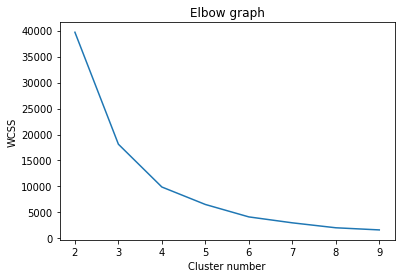

,Total_Score
customer_id,
267336573,16
313714285,10
399541992,6
953385604,15
1079947012,13
...,...
3939751100509,9
3939885088861,8
3940756815965,11


In [ ]:
tmp_rfmv = create_Usr_cluster(df_rfmv)
tmp_rfmv

In [ ]:
# Apply KMean clustering using the optimal number with the "elbow" on the graph above
for i in range(9):
  kmeans = KMeans(n_clusters=i+1, 
                  init='random', 
                  random_state=None)
  clusters = kmeans.fit_predict(tmp_rfmv)
  
  # how may members allocated in each cluster
  print("#Cluster",i+1,Counter(clusters))

#Cluster 1 Counter({0: 13083})
#Cluster 2 Counter({1: 7557, 0: 5526})
#Cluster 3 Counter({2: 5007, 1: 4365, 0: 3711})
#Cluster 4 Counter({2: 4911, 1: 3536, 3: 2475, 0: 2161})
#Cluster 5 Counter({3: 3536, 4: 2918, 0: 2475, 1: 2161, 2: 1993})
#Cluster 6 Counter({2: 3149, 5: 2604, 0: 2550, 1: 1858, 4: 1496, 3: 1426})
#Cluster 7 Counter({6: 3149, 5: 1993, 2: 1858, 3: 1714, 1: 1496, 4: 1447, 0: 1426})
#Cluster 8 Counter({4: 1993, 0: 1858, 2: 1714, 3: 1678, 7: 1496, 6: 1471, 1: 1447, 5: 1426})
#Cluster 9 Counter({0: 1993, 6: 1858, 3: 1714, 4: 1678, 5: 1496, 7: 1471, 1: 1447, 8: 759, 2: 667})


In [ ]:
kmeans = KMeans(n_clusters=4, 
                  init='random', 
                  random_state=None)
clusters = kmeans.fit_predict(tmp_rfmv)
  
### add the cluster result to the original rfmv dataframe
df_rfmv['clusters'] = clusters
df_rfmv

,customer_id,recency,frequency,monetary,variety,clusters
0,267336573,106,5,209.49,5,0
1,313714285,501,2,52.59,2,3
2,399541992,856,2,16.00,2,2
3,953385604,365,57,1326.91,46,0
4,1079947012,296,4,65.92,4,0
...,...,...,...,...,...,...
13078,3939751100509,64,2,21.66,2,1
13079,3939885088861,63,1,30.00,1,1
13080,3940756815965,63,2,67.50,2,3
13081,3940875534429,63,1,10.82,1,1


Counter({1: 4021, 2: 3536, 0: 2922, 3: 2604})


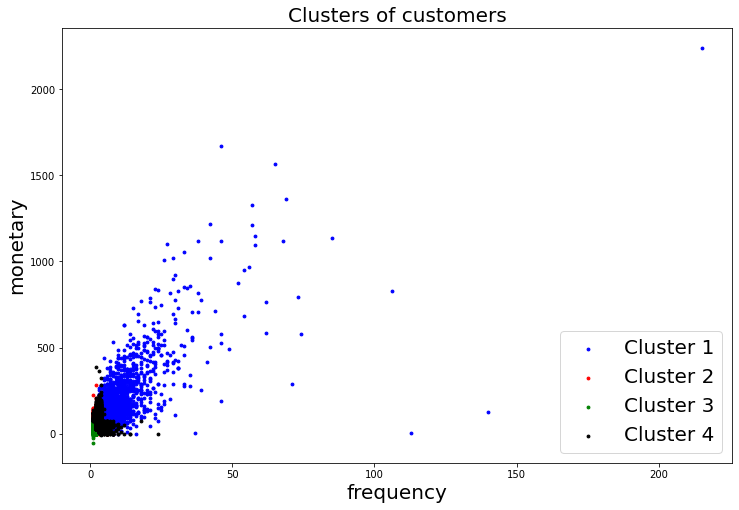

In [ ]:
### counter is a nice function to see how many counts belong to each unique value
### in this case we want to know how may members allocated in each cluster

print(Counter(clusters))

## optional: plot the two components with their respective RFMV to see the shape of the clusters
## optional: you can try to plot other RFMV components too

plot_cluster(df_rfmv)

In [ ]:
# Create Matrix of all customer Feature/metadata/embedding
# recency, frequency, monetary, variety, and cluster
matCoo_UsrRFMVCFeat = build_cooMat(df_rfmv, map_Usr2Idx, 
                                  ['rec','fre','mon','var','clu'], 
                                  'customer_id', 'titC', "way3")
matCoo_UsrRFMVCFeat

<13083x5 sparse matrix of type '<class 'numpy.float64'>'
	with 65415 stored elements in COOrdinate format>

In [ ]:
# Create Matrix recency Feature/metadata/embedding
matCoo_UsrRecFeat = build_cooMat(df_rfmv, map_Usr2Idx, [0], 
                                 'customer_id', 'recency', "way4")
matCoo_UsrRecFeat

<13083x1 sparse matrix of type '<class 'numpy.float64'>'
	with 13083 stored elements in COOrdinate format>

In [ ]:
# Create Matrix frequency Feature/metadata/embedding
matCoo_UsrFreFeat = build_cooMat(df_rfmv, map_Usr2Idx, [0], 
                                 'customer_id', 'frequency', "way4")
matCoo_UsrFreFeat

<13083x1 sparse matrix of type '<class 'numpy.float64'>'
	with 13083 stored elements in COOrdinate format>

In [ ]:
# Create Matrix monetary Feature/metadata/embedding
matCoo_UsrMonFeat = build_cooMat(df_rfmv, map_Usr2Idx, [0], 
                                 'customer_id', 'monetary', "way4")
matCoo_UsrMonFeat

<13083x1 sparse matrix of type '<class 'numpy.float64'>'
	with 13083 stored elements in COOrdinate format>

In [ ]:
# Create Matrix variety Feature/metadata/embedding
matCoo_UsrVarFeat = build_cooMat(df_rfmv, map_Usr2Idx, [0], 
                                 'customer_id', 'variety', "way4")
matCoo_UsrVarFeat

<13083x1 sparse matrix of type '<class 'numpy.float64'>'
	with 13083 stored elements in COOrdinate format>

In [ ]:
# Create Matrix clusters Feature/metadata/embedding
matCoo_UsrCluFeat = build_cooMat(df_rfmv, map_Usr2Idx, [0], 
                                 'customer_id', 'clusters', "way4")
matCoo_UsrCluFeat

<13083x1 sparse matrix of type '<class 'numpy.float64'>'
	with 13083 stored elements in COOrdinate format>

In [ ]:
print(df_DL.shape)
print(df_rfmv.shape)

df_DL = pd.merge(df_DL, df_rfmv, on="customer_id")
df_DL

(42796, 11)
(13083, 6)


,index,day,customer_id,order_id,net_sales,product_id,product_type,product_vendor,variant_sku,net_quantity,product_cat,recency,frequency,monetary,variety,clusters
0,1,2018-01-01,337253793819,275211943963,11.33,11606814671,sweatshirt,Stanley & Stella,STSW349C508,1,cat25,1205,2,46.33,2,1
1,2,2018-01-01,337253793819,275211943963,35.00,10461963983,dress,Komodo,C1 HF 38 FLORAL PRINT HEMP-4,1,cat18,1205,2,46.33,2,1
2,4,2018-01-02,185674203163,276031143963,16.20,89183715355,ls t-shirt,Stanley & Stella,STTW033C002110,1,cat26,931,6,183.07,6,0
3,1716,2018-03-20,185674203163,425030877211,21.67,316650225691,brassier,Organic Basics,F-BNI-C-BL-2,1,cat33,931,6,183.07,6,0
4,1899,2018-03-26,185674203163,439945887771,19.50,316683812891,underwear,Organic Basics,F-BNI-C-BL-3,1,cat33,931,6,183.07,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42791,71242,2021-02-16,3940894605405,3031524343901,36.66,4828228485213,slippers,Egos Shoes,EGOS-400-NATURALGREY,1,cat29,63,1,36.66,1,1
42792,71243,2021-02-16,3939885088861,3030724509789,30.00,4779231969373,underwear noos,THINX,THINX-THSS01010-BLACK,1,cat33,63,1,30.00,1,1
42793,71245,2021-02-16,3940756815965,3031371415645,37.50,4515734683741,top,Armedangels,AA-10253015-1302,1,cat26,63,2,67.50,2,3
42794,71248,2021-02-16,3940756815965,3031371415645,30.00,3546971603037,underwear noos,THINX,THINX-HIWAIST-BLACK,1,cat33,63,2,67.50,2,3


## Split Train Test

In [ ]:
print("Original:\n",
    "User:",len(df_DL['customer_id'].unique()), 
    "|| Clus:",len(df_DL['clusters'].unique()),
    "|| Prod:",len(df_DL['product_id'].unique()), 
    "|| Ven:",len(df_DL['product_vendor'].unique()), 
    "|| Cat:",len(df_DL['product_cat'].unique())    
)

df_DL_tr, df_DL_te = train_test_split(df_DL, test_size=0.2)

tr_cust = df_DL_tr['customer_id'].unique()
tr_custCl = df_DL_tr['clusters'].unique()
tr_prodId = df_DL_tr['product_id'].unique()
tr_prodVe = df_DL_tr['product_vendor'].unique()
tr_prodCa = df_DL_tr['product_cat'].unique()
print("Train desc: \n",
    "User:",len(tr_cust),"|| Clus:",len(tr_custCl), "|| Prod:",len(tr_prodId), "|| Ven:",len(tr_prodVe), "|| Cat:",len(tr_prodCa)
)

te_cust = df_DL_te['customer_id'].unique()
te_custCl = df_DL_te['clusters'].unique()
te_prodId = df_DL_te['product_id'].unique()
te_prodVe = df_DL_te['product_vendor'].unique()
te_prodCa = df_DL_te['product_cat'].unique()
print("Test desc:\n",
    "User:",len(te_cust), "|| Clus:",len(te_custCl), "|| Prod:",len(te_prodId), "|| Ven:",len(te_prodVe), "|| Cat:",len(te_prodCa)
)

Original:
 User: 13083 || Clus: 4 || Prod: 2576 || Ven: 110 || Cat: 40
Train desc: 
 User: 11898 || Clus: 4 || Prod: 2566 || Ven: 110 || Cat: 40
Test desc:
 User: 5356 || Clus: 4 || Prod: 2050 || Ven: 101 || Cat: 37


In [ ]:
# Non overlap cust and prod

print("custId:", set(tr_cust.tolist()) ^ set(te_cust.tolist()))
print("custCl:", set(tr_custCl.tolist()) ^ set(te_custCl.tolist()))
print("prodId:", set(tr_prodId.tolist()) ^ set(te_prodId.tolist()))
print("prodCat:", set(tr_prodCa.tolist()) ^ set(te_prodCa.tolist()))
print("prodVen:", set(tr_prodVe.tolist()) ^ set(te_prodVe.tolist()))

custId: {3903374688349, 1083534180445, 629928591453, 1913402392669, 882878677085, 1164987564125, 3358876991581, 480944422939, 1191730446429, 699621146717, 1163427283037, 5742755855, 5581684751, 3353540722781, 1712305504349, 660038516829, 3858162909277, 504046125083, 83056754715, 505110102043, 322134016027, 283830124571, 424740913179, 502683893787, 477751148571, 480910114843, 308892336155, 1862629326941, 751994404957, 2805844410461, 1910192734301, 847624536157, 1801843114077, 1120120078429, 3894031417437, 599959273565, 611703324765, 3398518046813, 2450372755549, 601384124509, 1811848396893, 4985323588, 2974047567965, 1956240982109, 3860891205725, 690634915933, 3877224546397, 3434414375005, 2167504964, 3772223619165, 3815676608605, 2833907482717, 125475127323, 3881509093469, 1910098264157, 1156837113949, 1245952475229, 1856906362973, 3846013091933, 682911039581, 3848134164573, 675451699293, 1798959792221, 3752387674205, 608946651229, 882830245981, 880871276637, 2798737293405, 62056808457

## User's Matric (features)

### Train users

In [ ]:
print("Total customer:", df_DL_tr['customer_id'].nunique())
df_cust_tr = df_DL_tr[['customer_id','recency','frequency','monetary','variety','clusters']]
df_cust_tr = df_cust_tr.drop_duplicates()
df_cust_tr = df_cust_tr.reset_index()
df_cust_tr = df_cust_tr.drop(['index'], axis=1)
df_cust_tr

Total customer: 11898


,customer_id,recency,frequency,monetary,variety,clusters
0,3470218821725,142,23,114.13,12,0
1,5681353615,500,11,299.15,11,0
2,3768403427421,206,2,33.33,2,3
3,629440741469,137,15,461.79,14,0
4,679381893213,472,15,220.16,14,0
...,...,...,...,...,...,...
11893,3852980158557,142,1,55.00,1,1
11894,1934805467229,628,1,41.58,1,2
11895,3387929296989,309,1,15.00,1,2
11896,612081369181,1059,1,33.75,1,2


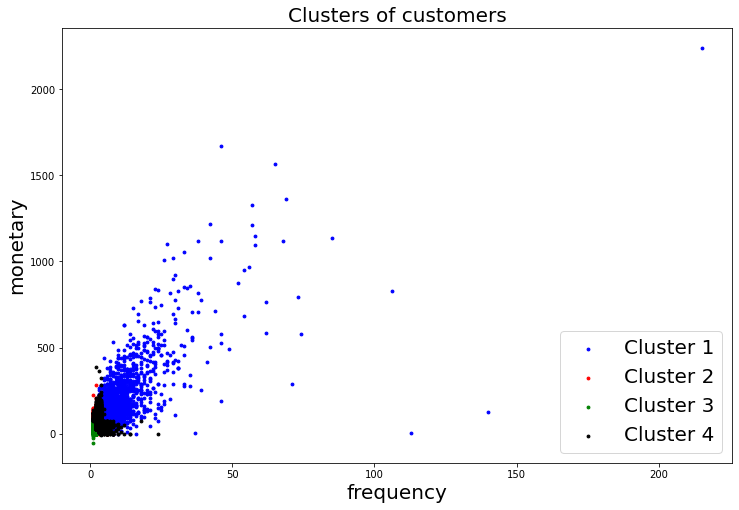

In [ ]:
plot_cluster(df_cust_tr)

### Test user

In [ ]:
print("Total customer:", df_DL_te['customer_id'].nunique())
df_cust_te = df_DL_te[['customer_id','recency','frequency','monetary','variety','clusters']]
df_cust_te = df_cust_te.drop_duplicates()
df_cust_te = df_cust_te.reset_index()
df_cust_te = df_cust_te.drop(['index'], axis=1)
df_cust_te

Total customer: 5356


,customer_id,recency,frequency,monetary,variety,clusters
0,3377987911773,155,7,88.63,7,0
1,679381893213,472,15,220.16,14,0
2,1182959665245,724,16,451.90,16,0
3,3785171763293,190,2,52.50,2,3
4,1818298679389,689,2,27.50,2,1
...,...,...,...,...,...,...
5351,3843993403485,85,4,106.67,2,0
5352,1159934181469,502,2,138.09,2,3
5353,885327855709,466,5,101.02,5,0
5354,1148062761053,841,2,17.50,2,2


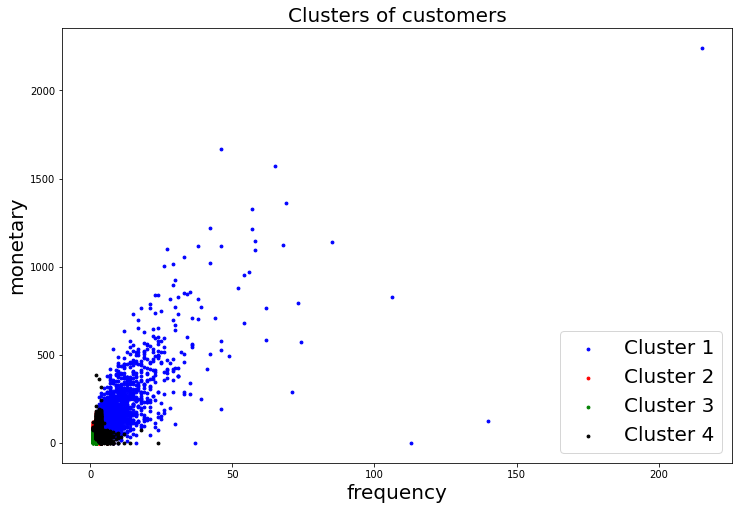

In [ ]:
plot_cluster(df_cust_te)

## Product's Matric (features)

### Train products

In [ ]:
print("Total product:", df_DL_tr['product_id'].nunique())
df_prod_tr = df_DL_tr[['product_id','product_cat','product_vendor','variant_sku']]
df_prod_tr = df_prod_tr.drop_duplicates()
df_prod_tr = df_prod_tr.reset_index()
df_prod_tr = df_prod_tr.drop(['index'], axis=1)
df_prod_tr

Total product: 2566


,product_id,product_cat,product_vendor,variant_sku
0,4756976435293,cat26,Stanley & Stella,SS-CREATOR-BRITISHKHAKI
1,1985679753309,cat26,Thought,THO-WST4194-WHITE
2,4397402718301,cat39,Dopper,DOP-2387
3,10029369615,cat2,People Tree,PPT-L801UO.BK1
4,1297347608669,cat1,People Tree,PPT-T457UU.BS1
...,...,...,...,...
2956,11821382991,cat18,People Tree,M796UP.BK1.16
2957,4782040973405,cat17,People Tree,PT-Y057UA.BKX-BLACK
2958,587446681627,cat26,People Tree,T320UU.WH1.12
2959,44465127451,cat18,Armedangels,10252819M


### Test product

In [ ]:
print("Total product:", df_DL_te['product_id'].nunique())
df_prod_te = df_DL_te[['product_id','product_cat','product_vendor','variant_sku']]
df_prod_te = df_prod_te.drop_duplicates()
df_prod_te = df_prod_te.reset_index()
df_prod_te = df_prod_te.drop(['index'], axis=1)
df_prod_te

Total product: 2050


,product_id,product_cat,product_vendor,variant_sku
0,4787382026333,cat25,Stanley & Stella,SS-RISE-BLACK
1,3824501572,cat26,Stanley & Stella,STTW033C0011X
2,1926768033885,cat19,Lucy & Yak,LY-ATLAS-MW
3,4756995801181,cat1,Yala Jewellery,YALA-JANONIEARRINGS-BRASS
4,1563548581981,cat31,Sancho's,SAN-SOAP-4
...,...,...,...,...
2222,101595545627,cat25,People Tree,R376US.OR1.12
2223,1485087473757,cat29,Ethletic,ETH-11000-001015
2224,1948080341085,cat26,Armedangels,AA-30000500-1029
2225,4782040318045,cat26,People Tree,PT-Y055UA.WH1-WHITE


## Integration Matric

In [ ]:
# Take 3 columns only as simple df

df_sales_simple = df_sales[['customer_id','product_id']]
df_sales_simple

df_sales_clean = df_sales_simple.dropna()
df_sales_clean = df_sales_clean[df_sales_clean['customer_id'] != 0]
df_sales_clean = df_sales_clean[df_sales_clean['product_id'] != 0]
df_sales_clean

,customer_id,product_id
1,337253793819,11606814671
2,337253793819,10461963983
4,185674203163,89183715355
5,338242994203,265754771483
7,338237554715,413081370651
...,...,...
71250,1927237763165,4399595028573
71255,3906919235677,4839341457501
71256,3906919235677,4839341555805
71257,3906919235677,1296876470365


### Train interaction

In [ ]:
# Here, np_user and np_prod are derived from training dataset alone

np_user_tr = np.sort(df_cust_tr['customer_id'].unique())
print("Total users:",len(np_user_tr))

np_prod_tr = np.sort(df_prod_tr['product_id'].unique())
print("Total products:",len(np_prod_tr))

df_clean_tr = create_cleanTrTe(np_user_tr, np_prod_tr, df_DL_tr)
df_clean_tr

Total users: 11898
Total products: 2566
Total row/users: 11898
Total col/products: 2566


,index,day,customer_id,order_id,net_sales,product_id,product_type,product_vendor,variant_sku,net_quantity,product_cat,recency,frequency,monetary,variety,clusters
36258,63560,2020-11-29,3470218821725,2906466222173,9.00,4756976435293,t-shirt,Stanley & Stella,SS-CREATOR-BRITISHKHAKI,1,cat26,142,23,114.13,12,0
306,28236,2019-06-29,5681353615,1133200736349,30.75,1985679753309,top,Thought,THO-WST4194-WHITE,1,cat26,500,11,299.15,11,0
37367,57214,2020-09-26,3768403427421,2802175836253,28.75,4397402718301,plastic free,Dopper,DOP-2387,1,cat39,206,2,33.33,2,3
6354,64529,2020-12-04,629440741469,2916660248669,32.50,10029369615,leggings,People Tree,PPT-L801UO.BK1,1,cat2,137,15,461.79,14,0
7899,7697,2018-08-18,679381893213,567418126429,15.00,1297347608669,earrings,People Tree,PPT-T457UU.BS1,1,cat1,472,15,220.16,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33657,50834,2020-06-27,3407005089885,2452019773533,9.71,1973770190941,underwear,Thought,THO-WAC4860-BLACK,1,cat33,285,4,45.72,2,3
18870,23485,2019-04-08,1681389256797,1013774483549,-6.00,1563693088861,candles,Sancho's,SAN-VC-8,-1,cat11,155,19,333.33,13,0
24652,31805,2019-08-28,1990118801501,1232838983773,18.33,11821382095,leggings,People Tree,PPT-H620UK.BK1,1,cat2,593,3,35.00,2,1
4236,16369,2018-12-15,258064646171,810682187869,15.17,11749259087,throw,Namaste,TH7,1,cat7,501,46,190.81,29,0


In [ ]:
df_CustProd_tr = pd.crosstab(df_clean_tr['customer_id'],df_clean_tr['product_id'])
df_CustProd_tr

product_id,3824501572,6450964228,6455427716,9523757444,10029359759,10029369615,10151973839,10152120079,10152153807,10152481231,10152481359,10152551631,10344777487,10344976847,10345399695,10448561103,10448567695,10451713487,10461963983,10605417999,10605471695,10605493135,10606036559,10606127567,10606129615,10606204431,10629444303,10881162063,11546278863,11561637647,11562112911,11606814671,11618125583,11636740239,11644967119,11645003343,11678627023,11701496783,11706567759,11706570511,...,4827797553245,4827797586013,4827797618781,4827797651549,4827797717085,4827797749853,4827797782621,4827802173533,4828226650205,4828228485213,4828462547037,4828465496157,4828472606813,4828472737885,4832853721181,4832854081629,4832854278237,4834168111197,4834169421917,4834174795869,4835293364317,4835321249885,4837472665693,4838064619613,4838065209437,4839340146781,4839340310621,4839340474461,4839340539997,4839341457501,4839341555805,4839353942109,4839607304285,4839607828573,4839610351709,4839620608093,4839944585309,4841097298013,4841351118941,4841351741533
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
267336573,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313714285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
953385604,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1079947012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1242435268,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939751100509,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3939885088861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3940756815965,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
matCoo_UsrProd_tr = build_cooMat(df_CustProd_tr, map_Usr2Idx, map_Pro2Idx, 
                                 'customer_id', 'product_id', "way2")
matCoo_UsrProd_tr

<13083x2576 sparse matrix of type '<class 'numpy.int64'>'
	with 31001 stored elements in COOrdinate format>

### Test interaction

In [ ]:
# Here, np_user and np_prod are derived from teaining dataset alone

np_user_te = np.sort(df_cust_te['customer_id'].unique())
print("Total users:",len(np_user_te))

np_prod_te = np.sort(df_prod_te['product_id'].unique())
print("Total products:",len(np_prod_te))

df_clean_te = create_cleanTrTe(np_user_te, np_prod_te, df_DL_te)
df_clean_te

Total users: 5356
Total products: 2050
Total row/users: 5356
Total col/products: 2050


,index,day,customer_id,order_id,net_sales,product_id,product_type,product_vendor,variant_sku,net_quantity,product_cat,recency,frequency,monetary,variety,clusters
32565,61542,2020-11-16,3377987911773,2879424266333,15.00,4787382026333,sweatshirt,Stanley & Stella,SS-RISE-BLACK,1,cat25,155,7,88.63,7,0
7904,9159,2018-09-15,679381893213,585459335261,15.00,3824501572,ls t-shirt,Stanley & Stella,STTW033C0011X,1,cat26,472,15,220.16,14,0
17066,20568,2019-02-12,1182959665245,862467817565,50.00,1926768033885,dungarees,Lucy & Yak,LY-ATLAS-MW,1,cat19,724,16,451.90,16,0
37917,58377,2020-10-12,3785171763293,2824893005917,37.50,4756995801181,earrings,Yala Jewellery,YALA-JANONIEARRINGS-BRASS,1,cat1,190,2,52.50,2,3
21112,26907,2019-06-01,1818298679389,1092985552989,3.33,1563548581981,soap,Sancho's,SAN-SOAP-4,1,cat31,689,2,27.50,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13444,15076,2018-12-03,885327855709,666478018653,11.25,1297347575901,earrings,People Tree,PPT-U471UV.BS1,1,cat1,466,5,101.02,5,0
15656,18418,2018-12-31,1148062761053,826425475165,7.00,685165707291,underwear,Thought,MAC3428,1,cat33,841,2,17.50,2,2
14603,16728,2018-12-17,1111417159773,812888195165,5.00,1563692859485,candles,Sancho's,SAN-VC-1,1,cat11,855,4,30.00,4,3
14908,38651,2019-11-30,1120311312477,1928419967069,4.36,4271490596957,socks,Doris & Dude,DDS709,1,cat32,507,11,80.91,11,0


In [ ]:
df_CustProd_te = pd.crosstab(df_clean_te['customer_id'],df_clean_te['product_id'])
df_CustProd_te

product_id,3824501572,6450964228,6455427716,9523757444,10029369615,10151973839,10152120079,10152153807,10152481231,10152481359,10152551631,10344777487,10345399695,10448567695,10451713487,10461963983,10605417999,10605471695,10605493135,10606127567,10606129615,10629444303,11546278863,11561637647,11562112911,11606814671,11636740239,11678627023,11749257103,11749259087,11749295759,11798542287,11798859983,11798867535,11821371919,11821382095,11844608207,11860528975,11860536911,11867652687,...,4826017857629,4826017923165,4826017988701,4826018054237,4826018087005,4826018119773,4826018218077,4826114883677,4826120781917,4826120814685,4826120880221,4826120912989,4826267091037,4826273480797,4827797553245,4827797586013,4827797651549,4827797717085,4827797782621,4828226650205,4828462547037,4828465496157,4828472606813,4828472737885,4832853721181,4832854081629,4832854278237,4834168111197,4838064619613,4838065209437,4839340146781,4839340539997,4839341359197,4839341457501,4839341555805,4839353942109,4839607304285,4839610351709,4841097298013,4841352233053
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
267336573,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
399541992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
953385604,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1079947012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1242435268,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939432202333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3939481649245,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3939491709021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
matCoo_UsrProd_te = build_cooMat(df_CustProd_te, map_Usr2Idx, map_Pro2Idx, 
                                 'customer_id', 'product_id', "way2")
matCoo_UsrProd_te

<13083x2576 sparse matrix of type '<class 'numpy.int64'>'
	with 8342 stored elements in COOrdinate format>

## Model with Ligthfm

### Without features

In [ ]:
# Model without any feature

tmpAuc, tmpPTr, tmpPTe, tmpRTr, tmpRTe = build_model(matCoo_UsrProd_tr, matCoo_UsrProd_te, 
            None,None,
            1000,4)

print("-"*75)
print("Append to dict_eval:")
dict_eval = {0:
  {"featTit":('None'),"auc": tmpAuc,
   "trP": tmpPTr,"teP": tmpPTe,"trR": tmpRTr,"teR": tmpRTe}
}
dict_eval

avg AUC = 0.77
train precision: 0.13736764
test precision: 0.021452576
train recall: 0.7860941579036236
test recall: 0.15948011108812077
---------------------------------------------------------------------------
Append to dict_eval:


{0: {'auc': 0.7728554,
  'featTit': 'None',
  'teP': 0.021452576,
  'teR': 0.15948011108812077,
  'trP': 0.13736764,
  'trR': 0.7860941579036236}}

### With product features

In [ ]:
# Model with all product feature

tmpAuc, tmpPTr, tmpPTe, tmpRTr, tmpRTe = build_model(matCoo_UsrProd_tr, matCoo_UsrProd_te, 
              None, matCoo_ProTVSCFeat,
              1000,4)

print("-"*75)
print("Append to dict_eval:")
dict_eval.update({len(dict_eval):
  {"featTit":('None'), "auc": tmpAuc,
   "trP": tmpPTr,"teP": tmpPTe,"trR": tmpRTr,"teR": tmpRTe}
})
dict_eval

avg AUC = 0.55
train precision: 0.0021684319
test precision: 0.0010268857
train recall: 0.009980233953872226
test recall: 0.006337347305420494
---------------------------------------------------------------------------
Append to dict_eval:


{0: {'auc': 0.7728554,
  'featTit': 'None',
  'teP': 0.021452576,
  'teR': 0.15948011108812077,
  'trP': 0.13736764,
  'trR': 0.7860941579036236},
 1: {'auc': 0.55202276,
  'featTit': 'None',
  'teP': 0.0010268857,
  'teR': 0.006337347305420494,
  'trP': 0.0021684319,
  'trR': 0.009980233953872226}}

In [ ]:
# WARNING: Can take long time to process

dictProdFeat = {"productTyp": matCoo_ProTypFeat, 
                "productVen": matCoo_ProVenFeat,
                "productSku": matCoo_ProSkuFeat, 
                "productCat": matCoo_ProCatFeat}
dictProdFeat

z=len(dict_eval)

for i in range(len(dictProdFeat)):
  i+=1; print(i)
  listFeat = list(itertools.permutations(
      dictProdFeat, i
      ))
  print(len(listFeat),listFeat)

  for j in listFeat:
    print(j, end=" ")
    listMat = []
    for k in j:
      #print(k)
      listMat.append(dictProdFeat[k])
    comMatFeat = hstack((listMat))
    print(comMatFeat.shape)

    tmpAuc, tmpPTr, tmpPTe, tmpRTr, tmpRTe = build_model(matCoo_UsrProd_tr, matCoo_UsrProd_te, 
              None, comMatFeat,
              1000,4)
    dict_eval.update({z:{"featTit":j, "auc": tmpAuc,
   "trP": tmpPTr,"teP": tmpPTe,"trR": tmpRTr,"teR": tmpRTe}})
    z+=1

    print("-"*50)
  print("="*50)

1
4 [('productTyp',), ('productVen',), ('productSku',), ('productCat',)]
('productTyp',) (2576, 134)
avg AUC = 0.60
train precision: 0.0067910575
test precision: 0.0029686333
train recall: 0.03739801822877045
test recall: 0.021682984677756898
--------------------------------------------------
('productVen',) (2576, 110)
avg AUC = 0.62
train precision: 0.010732897
test precision: 0.004648992
train recall: 0.07306275534291251
test recall: 0.03732383896218847
--------------------------------------------------
('productSku',) (2576, 2827)
avg AUC = 0.54
train precision: 0.0038409817
test precision: 0.0015123227
train recall: 0.016677016042610997
test recall: 0.01050053174773115
--------------------------------------------------
('productCat',) (2576, 40)
avg AUC = 0.67
train precision: 0.007925702
test precision: 0.004256908
train recall: 0.04161106987619665
test recall: 0.0315863566563716
--------------------------------------------------
2
12 [('productTyp', 'productVen'), ('productTyp',

### With user features

In [ ]:
# Model with all user feature

tmpAuc, tmpPTr, tmpPTe, tmpRTr, tmpRTe = build_model(matCoo_UsrProd_tr, matCoo_UsrProd_te, 
              matCoo_UsrRFMVCFeat, None,
              1000,4)

print("-"*75)
print("Append to dict_eval:")
dict_eval.update({len(dict_eval):
  {"featTit":('userRFMVC'), "auc": tmpAuc,
   "trP": tmpPTr,"teP": tmpPTe,"trR": tmpRTr,"teR": tmpRTe}
})
dict_eval

avg AUC = 0.53
train precision: 0.0013279543
test precision: 0.0008401792
train recall: 0.005071774161393521
test recall: 0.005596367680945724
---------------------------------------------------------------------------
Append to dict_eval:


{0: {'auc': 0.7728554,
  'featTit': 'None',
  'teP': 0.021452576,
  'teR': 0.15948011108812077,
  'trP': 0.13736764,
  'trR': 0.7860941579036236},
 1: {'auc': 0.55202276,
  'featTit': 'None',
  'teP': 0.0010268857,
  'teR': 0.006337347305420494,
  'trP': 0.0021684319,
  'trR': 0.009980233953872226},
 2: {'auc': 0.6006151,
  'featTit': ('productTyp',),
  'teP': 0.0029686333,
  'teR': 0.021682984677756898,
  'trP': 0.0067910575,
  'trR': 0.03739801822877045},
 3: {'auc': 0.6158862,
  'featTit': ('productVen',),
  'teP': 0.004648992,
  'teR': 0.03732383896218847,
  'trP': 0.010732897,
  'trR': 0.07306275534291251},
 4: {'auc': 0.53548473,
  'featTit': ('productSku',),
  'teP': 0.0015123227,
  'teR': 0.01050053174773115,
  'trP': 0.0038409817,
  'trR': 0.016677016042610997},
 5: {'auc': 0.6668235,
  'featTit': ('productCat',),
  'teP': 0.004256908,
  'teR': 0.0315863566563716,
  'trP': 0.007925702,
  'trR': 0.04161106987619665},
 6: {'auc': 0.62360096,
  'featTit': ('productTyp', 'productV

In [ ]:
# WARNING: Can take long time to process

dictUserFeat = {"userRec": matCoo_UsrRecFeat, 
                "userFre": matCoo_UsrFreFeat,
                "userMon": matCoo_UsrMonFeat, 
                "userVar": matCoo_UsrVarFeat,
                "userClu": matCoo_UsrCluFeat}
dictUserFeat

z=len(dict_eval)

for i in range(len(dictUserFeat)):
  i+=1; print(i)
  listFeat = list(itertools.permutations(
      dictUserFeat, i
      ))
  print(len(listFeat),listFeat)

  for j in listFeat:
    print(j, end=" ")
    listMat = []
    for k in j:
      #print(k)
      listMat.append(dictUserFeat[k])
    comMatFeat = hstack((listMat))
    print(comMatFeat.shape)

    tmpAuc, tmpPTr, tmpPTe, tmpRTr, tmpRTe = build_model(matCoo_UsrProd_tr, matCoo_UsrProd_te, 
              comMatFeat, None,
              1000,4)
    dict_eval.update({z:{"featTit":j, "auc": tmpAuc,
   "trP": tmpPTr,"teP": tmpPTe,"trR": tmpRTr,"teR": tmpRTe}})
    z+=1

    print("-"*50)
  print("="*50)

1
5 [('userRec',), ('userFre',), ('userMon',), ('userVar',), ('userClu',)]
('userRec',) (13083, 1)
avg AUC = 0.50
train precision: 0.00026895278
test precision: 0.00024271844
train recall: 0.001127621296977491
test recall: 0.0019915359721184964
--------------------------------------------------
('userFre',) (13083, 1)
avg AUC = 0.76
train precision: 0.017120525
test precision: 0.010642271
train recall: 0.08163766807933087
test recall: 0.07655427770719032
--------------------------------------------------
('userMon',) (13083, 1)
avg AUC = 0.56
train precision: 0.0007480249
test precision: 0.00061613147
train recall: 0.00334898008707887
test recall: 0.004108179441917306
--------------------------------------------------
('userVar',) (13083, 1)
avg AUC = 0.76
train precision: 0.017053287
test precision: 0.010810305
train recall: 0.07997077104376824
test recall: 0.07873596535611098
--------------------------------------------------
('userClu',) (13083, 1)
avg AUC = 0.76
train precision: 0.

### With user and product features

In [ ]:
dictProdFeat.update({'productTVSC':matCoo_ProTVSCFeat})
dictProdFeat

{'productCat': <2576x40 sparse matrix of type '<class 'numpy.int64'>'
 	with 42796 stored elements in COOrdinate format>,
 'productSku': <2576x2827 sparse matrix of type '<class 'numpy.int64'>'
 	with 42796 stored elements in COOrdinate format>,
 'productTVSC': <2576x3111 sparse matrix of type '<class 'numpy.longlong'>'
 	with 171184 stored elements in COOrdinate format>,
 'productTyp': <2576x134 sparse matrix of type '<class 'numpy.int64'>'
 	with 42796 stored elements in COOrdinate format>,
 'productVen': <2576x110 sparse matrix of type '<class 'numpy.int64'>'
 	with 42796 stored elements in COOrdinate format>}

In [ ]:
dictUserFeat.update({'userRFMVC':matCoo_UsrRFMVCFeat})
dictUserFeat

{'userClu': <13083x1 sparse matrix of type '<class 'numpy.float64'>'
 	with 13083 stored elements in COOrdinate format>,
 'userFre': <13083x1 sparse matrix of type '<class 'numpy.float64'>'
 	with 13083 stored elements in COOrdinate format>,
 'userMon': <13083x1 sparse matrix of type '<class 'numpy.float64'>'
 	with 13083 stored elements in COOrdinate format>,
 'userRFMVC': <13083x5 sparse matrix of type '<class 'numpy.float64'>'
 	with 65415 stored elements in COOrdinate format>,
 'userRec': <13083x1 sparse matrix of type '<class 'numpy.float64'>'
 	with 13083 stored elements in COOrdinate format>,
 'userVar': <13083x1 sparse matrix of type '<class 'numpy.float64'>'
 	with 13083 stored elements in COOrdinate format>}

In [ ]:
z=len(dict_eval)

for key,val in dictUserFeat.items():
  for key2,val2 in dictProdFeat.items():
    print(key,key2)
    tmpAuc, tmpPTr, tmpPTe, tmpRTr, tmpRTe = build_model(matCoo_UsrProd_tr, matCoo_UsrProd_te, 
            dictUserFeat[key], dictProdFeat[key2],
            1000,4)
    dict_eval.update({z:
      {"featTit":(key, key2), "auc": tmpAuc,
   "trP": tmpPTr,"teP": tmpPTe,"trR": tmpRTr,"teR": tmpRTe}
    })

userRec productTyp
avg AUC = 0.55
train precision: 0.01114473
test precision: 0.0069828224
train recall: 0.06235201728476906
test recall: 0.05363979073370411
userRec productVen
avg AUC = 0.57
train precision: 0.009430157
test precision: 0.006254668
train recall: 0.0601532728185403
test recall: 0.05180385490785042
userRec productSku
avg AUC = 0.60
train precision: 0.012556733
test precision: 0.007935026
train recall: 0.06725143689692956
test recall: 0.0608199285570458
userRec productCat
avg AUC = 0.58
train precision: 0.007194487
test precision: 0.004088872
train recall: 0.027692894638178617
test recall: 0.027845312603060925
userRec productTVSC
avg AUC = 0.65
train precision: 0.012506303
test precision: 0.008681852
train recall: 0.07022785440121555
test recall: 0.06777726930359491
userFre productTyp
avg AUC = 0.72
train precision: 0.008463607
test precision: 0.0053024646
train recall: 0.039932047072365445
test recall: 0.03606533703621082
userFre productVen
avg AUC = 0.70
train precision

In [ ]:
# Save evaluation data 

with open('dict_eval.p', 'wb') as fp:
    pickle.dump(dict_eval, fp, protocol=pickle.HIGHEST_PROTOCOL)

### Visualize the evaluation metrics

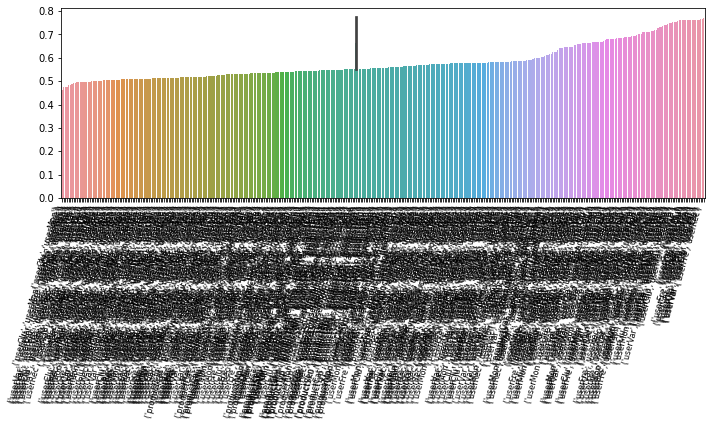

In [ ]:
with open('dict_eval.p', 'rb') as fp: dict_eval = pickle.load(fp)

dict_eval = sorted(dict_eval.items(),key=lambda x:getitem(x[1],'auc'))

snsX = [] ; snsY = []
for i in dict_eval:
  #print(i[1])
  snsX.append(str(i[1]['featTit']))
  snsY.append(i[1]['auc'])

plt.figure(figsize=(10,6))
ax=sns.barplot(x=snsX, y=snsY)
ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha="right", fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
tmp_list = []
for i in dict_eval:
  #print(i[0], i[1]['featTit'], i[1]['auc'])
  tmp_list.append([i[0], i[1]['featTit'], 
                   i[1]['auc'], i[1]['trP'], i[1]['teP'],
                   i[1]['trR'], i[1]['teR']])
df_eval = pd.DataFrame(tmp_list, columns=['id','featTit','auc','trP','teP','trR','teR'])
df_eval
df_eval.sort_values(by=['auc'], ascending=False).iloc[:10]

,id,featTit,auc,trP,teP,trR,teR
0,90,"(userClu, userMon)",0.463367,0.000563,0.000467,0.001632,0.002392
1,260,"(userClu, userMon, userRec, userFre)",0.474487,0.000874,0.000411,0.002474,0.001970
2,234,"(userVar, userFre, userClu, userRec)",0.475581,0.000361,0.000149,0.001470,0.000706
3,88,"(userClu, userRec)",0.476191,0.000244,0.000168,0.001338,0.001369
4,364,"(userVar, userClu, userFre, userRec, userMon)",0.481774,0.000740,0.000392,0.002888,0.002464
...,...,...,...,...,...,...,...
388,145,"(userClu, userFre, userVar)",0.763878,0.017516,0.010680,0.086766,0.079471
389,138,"(userVar, userClu, userFre)",0.764096,0.017953,0.010717,0.088049,0.078722
390,133,"(userVar, userFre, userClu)",0.764116,0.017911,0.010642,0.087400,0.078368
391,76,"(userFre, userRec)",0.770824,0.011380,0.007132,0.056935,0.050617


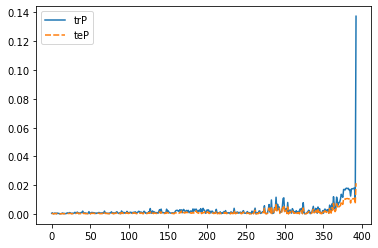

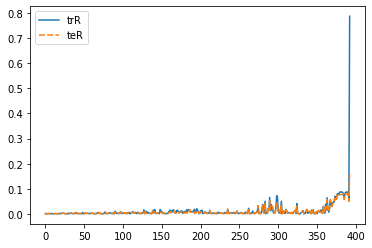

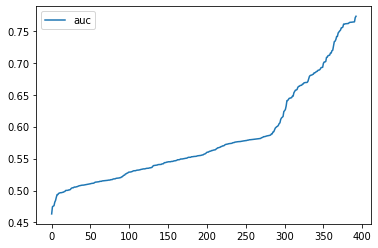

In [ ]:
# Plot the evaluation matrics for precision, recall, and AUC

sns.lineplot(data=df_eval[['trP','teP']])
plt.show()
sns.lineplot(data=df_eval[['trR','teR']])
plt.show()
sns.lineplot(data=df_eval[['auc']])
plt.show()

## Requesting Products / Items Recommendation

we need to combine the training and the test set and retrain everything

In [ ]:
# Join the train and test matrix again

matCoo_UsrProd_all = combined_train_test(matCoo_UsrProd_tr, matCoo_UsrProd_te)
matCoo_UsrProd_all

<13083x2576 sparse matrix of type '<class 'numpy.float64'>'
	with 37943 stored elements in COOrdinate format>

In [ ]:
# Join all products (train and test)

df_prod_all = df_DL[['product_id','product_type','product_vendor','variant_sku','product_cat']]
df_prod_all

dictProd = df_prod_all.set_index('product_id').T.to_dict('list')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  


In [ ]:
# Join all customers (train and test)

df_cust = pd.concat([df_cust_tr, df_cust_te])
df_cust

dictUser = df_cust.set_index('customer_id').T.to_dict('list')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  


In [ ]:
# Because pure collaborative gains the best result, we build our final model on it.

final_model = LightFM(loss = "warp")
start = time.time()
final_model.fit(matCoo_UsrProd_all,
          user_features=None, item_features=None, 
          sample_weight=None, 
          epochs=1000, num_threads=4,
          verbose=False)
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 26.05 seconds


In [ ]:
# Example of recommendation for customer 399541992

recommendation_for_user(final_model, 399541992, prod, dictProd, dictUser,
                            map_Usr2Idx,
                            matCoo_UsrProd_all, 7)

User: 399541992 with features: [856.0, 2.0, 16.0, 2.0, 2.0]
     Known positives:
        1305215402077 ['t-shirt', 'Stanley & Stella', 'SS-BEARS-WHITE', 'cat26']
        1410668134493 ['dress', 'People Tree', 'PPT-U318UV.MC1', 'cat18']
     Recommended product:
        3732673036381 ['candle', "Sancho's", 'CHEL-MINI', 'cat11']
        1508536942685 ['homewares', 'Clare Elizabeth Kilgour', 'CEK-B-PH-1-L', 'cat22']
        1414028263517 ['candles noos', "Sancho's", 'CHEL-MINI', 'cat11']
        650481762331 ['shirt', 'Thought', 'MST3713', 'cat26']
        439037689883 ['socks', 'Thought', 'THO-SPM250-BLUE', 'cat32']
        4471432806493 ['soap', 'Soap Daze', 'SDAZE-BOXED', 'cat31']
        1580209045597 ['underwear', 'People Tree', 'PPT-M715UP.BK1', 'cat33']
